In [1]:

import tensorflow as tf

import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model


#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/btc/bitcoin2000.csv?token=ATB7FV6HV4GIIPV3ROVNEEDBOATHY')

In [3]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

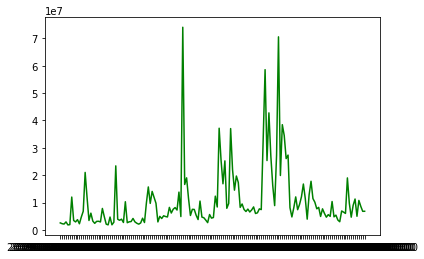

In [5]:
plt.plot(data['volumeto'][40:200],'g')

In [6]:
data.columns[1:7]

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close'], dtype='object')

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[1:7]].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [8]:
values.min(axis=0)

array([4.6234502e+03, 3.9489199e+03, 4.2406899e+03, 1.6186000e+02,
       1.1648342e+06, 4.2406899e+03], dtype=float32)

In [9]:
np.max(values)

7859574300.0

In [10]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],values[train_size+val_size:,:]
print(len(train),len(val), len(test),len(test1))

8004 1000 1001 1001


In [11]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

7980
976
977
977


In [13]:
print(trainX.shape)
print(trainY.shape)

(7980, 24, 6)
(7980,)


In [14]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

## bidirectional LSTM

In [15]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 180)               69840     
_________________________________________________________________
dense (Dense)                (None, 100)               18100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
246/250 [============================>.] - ETA: 0s - loss: 4.0694e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(1).hd

246/250 [============================>.] - ETA: 0s - loss: 4.9640e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9264e-06 - val_loss: 0.0000e+00
Epoch 33/200
247/250 [============================>.] - ETA: 0s - loss: 4.9889e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9754e-06 - val_loss: 0.0000e+00
Epoch 34/200
244/250 [============================>.] - ETA: 0s - loss: 4.8356e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.8106e-06 - val_loss: 0.0000e+00
Epoch 35/200
249/250 [============================>.] - ETA: 0s - loss: 4.2251e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.3454e-06 - val_loss: 0.0000e+00
Epoch 36/200
243/250 [============================>.] - ETA: 0s - loss: 5.3671e-06
Epoch 

Epoch 68/200
244/250 [============================>.] - ETA: 0s - loss: 3.9254e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9673e-06 - val_loss: 0.0000e+00
Epoch 69/200
243/250 [============================>.] - ETA: 0s - loss: 3.8121e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8239e-06 - val_loss: 0.0000e+00
Epoch 70/200
247/250 [============================>.] - ETA: 0s - loss: 3.3747e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3735e-06 - val_loss: 0.0000e+00
Epoch 71/200
246/250 [============================>.] - ETA: 0s - loss: 3.6390e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6402e-06 - val_loss: 0.0000e+00
Epoch 72/200
250/250 [==============================] - ETA: 0s - loss: 4.26

Epoch 104/200
249/250 [============================>.] - ETA: 0s - loss: 3.9172e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.9190e-06 - val_loss: 0.0000e+00
Epoch 105/200
247/250 [============================>.] - ETA: 0s - loss: 3.8864e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.8695e-06 - val_loss: 0.0000e+00
Epoch 106/200
246/250 [============================>.] - ETA: 0s - loss: 4.2766e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 4.3225e-06 - val_loss: 0.0000e+00
Epoch 107/200
243/250 [============================>.] - ETA: 0s - loss: 3.7796e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.7885e-06 - val_loss: 0.0000e+00
Epoch 108/200
246/250 [============================>.] - ETA: 0s - loss:

248/250 [============================>.] - ETA: 0s - loss: 3.4144e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 9ms/step - loss: 3.4042e-06 - val_loss: 0.0000e+00
Epoch 140/200
246/250 [============================>.] - ETA: 0s - loss: 3.4841e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 10ms/step - loss: 3.4698e-06 - val_loss: 0.0000e+00
Epoch 141/200
245/250 [============================>.] - ETA: 0s - loss: 3.3505e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 9ms/step - loss: 3.3560e-06 - val_loss: 0.0000e+00
Epoch 142/200
246/250 [============================>.] - ETA: 0s - loss: 3.6386e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 9ms/step - loss: 3.6239e-06 - val_loss: 0.0000e+00
Epoch 143/200
244/250 [============================>.] - ETA: 0s - loss: 3.6934e-06
E

Epoch 175/200
248/250 [============================>.] - ETA: 0s - loss: 3.2574e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.3052e-06 - val_loss: 0.0000e+00
Epoch 176/200
243/250 [============================>.] - ETA: 0s - loss: 3.3653e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.4397e-06 - val_loss: 0.0000e+00
Epoch 177/200
245/250 [============================>.] - ETA: 0s - loss: 3.4336e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.5003e-06 - val_loss: 0.0000e+00
Epoch 178/200
249/250 [============================>.] - ETA: 0s - loss: 3.4533e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4518e-06 - val_loss: 0.0000e+00
Epoch 179/200
245/250 [============================>.] - ETA: 0s - loss:

In [16]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
247/250 [============================>.] - ETA: 0s - loss: 4.3512e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(2).hd

245/250 [============================>.] - ETA: 0s - loss: 4.9359e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.8983e-06 - val_loss: 0.0000e+00
Epoch 33/200
250/250 [==============================] - ETA: 0s - loss: 4.9174e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9174e-06 - val_loss: 0.0000e+00
Epoch 34/200
248/250 [============================>.] - ETA: 0s - loss: 4.9408e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9512e-06 - val_loss: 0.0000e+00
Epoch 35/200
245/250 [============================>.] - ETA: 0s - loss: 6.2128e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 6.1868e-06 - val_loss: 0.0000e+00
Epoch 36/200
249/250 [============================>.] - ETA: 0s - loss: 4.6029e-06
Epoch 

Epoch 68/200
248/250 [============================>.] - ETA: 0s - loss: 4.3188e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.3111e-06 - val_loss: 0.0000e+00
Epoch 69/200
250/250 [==============================] - ETA: 0s - loss: 3.8679e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8679e-06 - val_loss: 0.0000e+00
Epoch 70/200
247/250 [============================>.] - ETA: 0s - loss: 4.0461e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.0322e-06 - val_loss: 0.0000e+00
Epoch 71/200
249/250 [============================>.] - ETA: 0s - loss: 4.2384e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.2342e-06 - val_loss: 0.0000e+00
Epoch 72/200
244/250 [============================>.] - ETA: 0s - loss: 4.15

Epoch 104/200
250/250 [==============================] - ETA: 0s - loss: 3.9302e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9302e-06 - val_loss: 0.0000e+00
Epoch 105/200
246/250 [============================>.] - ETA: 0s - loss: 3.8050e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7960e-06 - val_loss: 0.0000e+00
Epoch 106/200
245/250 [============================>.] - ETA: 0s - loss: 3.6376e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.6295e-06 - val_loss: 0.0000e+00
Epoch 107/200
249/250 [============================>.] - ETA: 0s - loss: 3.9951e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.9933e-06 - val_loss: 0.0000e+00
Epoch 108/200
245/250 [============================>.] - ETA: 0s - loss:

247/250 [============================>.] - ETA: 0s - loss: 3.5420e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5796e-06 - val_loss: 0.0000e+00
Epoch 140/200
243/250 [============================>.] - ETA: 0s - loss: 3.4500e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4372e-06 - val_loss: 0.0000e+00
Epoch 141/200
248/250 [============================>.] - ETA: 0s - loss: 3.6487e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6499e-06 - val_loss: 0.0000e+00
Epoch 142/200
249/250 [============================>.] - ETA: 0s - loss: 3.3200e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3184e-06 - val_loss: 0.0000e+00
Epoch 143/200
248/250 [============================>.] - ETA: 0s - loss: 3.4109e-06
Ep

Epoch 175/200
247/250 [============================>.] - ETA: 0s - loss: 3.3767e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3700e-06 - val_loss: 0.0000e+00
Epoch 176/200
247/250 [============================>.] - ETA: 0s - loss: 3.4599e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4441e-06 - val_loss: 0.0000e+00
Epoch 177/200
244/250 [============================>.] - ETA: 0s - loss: 3.6520e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6373e-06 - val_loss: 0.0000e+00
Epoch 178/200
246/250 [============================>.] - ETA: 0s - loss: 3.4188e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4170e-06 - val_loss: 0.0000e+00
Epoch 179/200
249/250 [============================>.] - ETA: 0s - loss:

In [17]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
247/250 [============================>.] - ETA: 0s - loss: 3.2339e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(3).hd

246/250 [============================>.] - ETA: 0s - loss: 5.0694e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.0499e-06 - val_loss: 0.0000e+00
Epoch 33/200
249/250 [============================>.] - ETA: 0s - loss: 5.3625e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.3588e-06 - val_loss: 0.0000e+00
Epoch 34/200
250/250 [==============================] - ETA: 0s - loss: 5.1227e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.1227e-06 - val_loss: 0.0000e+00
Epoch 35/200
247/250 [============================>.] - ETA: 0s - loss: 4.9057e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9069e-06 - val_loss: 0.0000e+00
Epoch 36/200
244/250 [============================>.] - ETA: 0s - loss: 4.3799e-06
Epoch 

Epoch 68/200
244/250 [============================>.] - ETA: 0s - loss: 3.8212e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8018e-06 - val_loss: 0.0000e+00
Epoch 69/200
243/250 [============================>.] - ETA: 0s - loss: 3.6700e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7266e-06 - val_loss: 0.0000e+00
Epoch 70/200
247/250 [============================>.] - ETA: 0s - loss: 3.4904e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5100e-06 - val_loss: 0.0000e+00
Epoch 71/200
245/250 [============================>.] - ETA: 0s - loss: 4.4401e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.4051e-06 - val_loss: 0.0000e+00
Epoch 72/200
246/250 [============================>.] - ETA: 0s - loss: 4.25

Epoch 104/200
245/250 [============================>.] - ETA: 0s - loss: 3.7355e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7409e-06 - val_loss: 0.0000e+00
Epoch 105/200
249/250 [============================>.] - ETA: 0s - loss: 3.5955e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5935e-06 - val_loss: 0.0000e+00
Epoch 106/200
246/250 [============================>.] - ETA: 0s - loss: 3.6689e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6523e-06 - val_loss: 0.0000e+00
Epoch 107/200
245/250 [============================>.] - ETA: 0s - loss: 3.9082e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9869e-06 - val_loss: 0.0000e+00
Epoch 108/200
245/250 [============================>.] - ETA: 0s - loss:

250/250 [==============================] - ETA: 0s - loss: 3.2907e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2907e-06 - val_loss: 0.0000e+00
Epoch 140/200
244/250 [============================>.] - ETA: 0s - loss: 3.5478e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5314e-06 - val_loss: 0.0000e+00
Epoch 141/200
244/250 [============================>.] - ETA: 0s - loss: 3.3349e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3417e-06 - val_loss: 0.0000e+00
Epoch 142/200
246/250 [============================>.] - ETA: 0s - loss: 3.5144e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5191e-06 - val_loss: 0.0000e+00
Epoch 143/200
247/250 [============================>.] - ETA: 0s - loss: 3.7849e-06
Ep

Epoch 175/200
247/250 [============================>.] - ETA: 0s - loss: 3.3231e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3209e-06 - val_loss: 0.0000e+00
Epoch 176/200
250/250 [==============================] - ETA: 0s - loss: 3.3397e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3397e-06 - val_loss: 0.0000e+00
Epoch 177/200
245/250 [============================>.] - ETA: 0s - loss: 3.3602e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3473e-06 - val_loss: 0.0000e+00
Epoch 178/200
248/250 [============================>.] - ETA: 0s - loss: 3.7023e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7020e-06 - val_loss: 0.0000e+00
Epoch 179/200
244/250 [============================>.] - ETA: 0s - loss:

In [18]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
249/250 [============================>.] - ETA: 0s - loss: 2.3591e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(4).hd

248/250 [============================>.] - ETA: 0s - loss: 4.7793e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.7643e-06 - val_loss: 0.0000e+00
Epoch 33/200
249/250 [============================>.] - ETA: 0s - loss: 4.5063e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.5022e-06 - val_loss: 0.0000e+00
Epoch 34/200
247/250 [============================>.] - ETA: 0s - loss: 4.5620e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.5555e-06 - val_loss: 0.0000e+00
Epoch 35/200
248/250 [============================>.] - ETA: 0s - loss: 5.2145e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.2299e-06 - val_loss: 0.0000e+00
Epoch 36/200
243/250 [============================>.] - ETA: 0s - loss: 5.3826e-06
Epoch 

Epoch 68/200
243/250 [============================>.] - ETA: 0s - loss: 4.3106e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.2843e-06 - val_loss: 0.0000e+00
Epoch 69/200
244/250 [============================>.] - ETA: 0s - loss: 3.8854e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9154e-06 - val_loss: 0.0000e+00
Epoch 70/200
244/250 [============================>.] - ETA: 0s - loss: 3.6302e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5935e-06 - val_loss: 0.0000e+00
Epoch 71/200
250/250 [==============================] - ETA: 0s - loss: 3.9048e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9048e-06 - val_loss: 0.0000e+00
Epoch 72/200
249/250 [============================>.] - ETA: 0s - loss: 4.11

Epoch 104/200
244/250 [============================>.] - ETA: 0s - loss: 4.3145e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.3223e-06 - val_loss: 0.0000e+00
Epoch 105/200
243/250 [============================>.] - ETA: 0s - loss: 3.5673e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5565e-06 - val_loss: 0.0000e+00
Epoch 106/200
247/250 [============================>.] - ETA: 0s - loss: 3.5230e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5059e-06 - val_loss: 0.0000e+00
Epoch 107/200
250/250 [==============================] - ETA: 0s - loss: 3.3630e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3630e-06 - val_loss: 0.0000e+00
Epoch 108/200
243/250 [============================>.] - ETA: 0s - loss:

248/250 [============================>.] - ETA: 0s - loss: 3.5077e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4969e-06 - val_loss: 0.0000e+00
Epoch 140/200
250/250 [==============================] - ETA: 0s - loss: 3.2910e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2910e-06 - val_loss: 0.0000e+00
Epoch 141/200
243/250 [============================>.] - ETA: 0s - loss: 3.5464e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5626e-06 - val_loss: 0.0000e+00
Epoch 142/200
244/250 [============================>.] - ETA: 0s - loss: 3.4663e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4559e-06 - val_loss: 0.0000e+00
Epoch 143/200
247/250 [============================>.] - ETA: 0s - loss: 4.0008e-06
Ep

Epoch 175/200
250/250 [==============================] - ETA: 0s - loss: 3.4594e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4594e-06 - val_loss: 0.0000e+00
Epoch 176/200
250/250 [==============================] - ETA: 0s - loss: 3.5463e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5463e-06 - val_loss: 0.0000e+00
Epoch 177/200
243/250 [============================>.] - ETA: 0s - loss: 3.3038e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2896e-06 - val_loss: 0.0000e+00
Epoch 178/200
243/250 [============================>.] - ETA: 0s - loss: 3.5362e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5604e-06 - val_loss: 0.0000e+00
Epoch 179/200
243/250 [============================>.] - ETA: 0s - loss:

In [19]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
243/250 [============================>.] - ETA: 0s - loss: 3.0085e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(5).hd

250/250 [==============================] - ETA: 0s - loss: 5.4941e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.4941e-06 - val_loss: 0.0000e+00
Epoch 33/200
244/250 [============================>.] - ETA: 0s - loss: 4.4459e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.4639e-06 - val_loss: 0.0000e+00
Epoch 34/200
247/250 [============================>.] - ETA: 0s - loss: 4.9685e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9522e-06 - val_loss: 0.0000e+00
Epoch 35/200
249/250 [============================>.] - ETA: 0s - loss: 4.7441e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.7432e-06 - val_loss: 0.0000e+00
Epoch 36/200
246/250 [============================>.] - ETA: 0s - loss: 5.9955e-06
Epoch 

Epoch 68/200
243/250 [============================>.] - ETA: 0s - loss: 3.8838e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8875e-06 - val_loss: 0.0000e+00
Epoch 69/200
249/250 [============================>.] - ETA: 0s - loss: 4.5409e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.5367e-06 - val_loss: 0.0000e+00
Epoch 70/200
247/250 [============================>.] - ETA: 0s - loss: 4.2072e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.1930e-06 - val_loss: 0.0000e+00
Epoch 71/200
243/250 [============================>.] - ETA: 0s - loss: 4.3188e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.2966e-06 - val_loss: 0.0000e+00
Epoch 72/200
248/250 [============================>.] - ETA: 0s - loss: 3.81

Epoch 104/200
244/250 [============================>.] - ETA: 0s - loss: 3.5590e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6036e-06 - val_loss: 0.0000e+00
Epoch 105/200
249/250 [============================>.] - ETA: 0s - loss: 3.8892e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8880e-06 - val_loss: 0.0000e+00
Epoch 106/200
245/250 [============================>.] - ETA: 0s - loss: 3.6859e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6912e-06 - val_loss: 0.0000e+00
Epoch 107/200
243/250 [============================>.] - ETA: 0s - loss: 3.4581e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5360e-06 - val_loss: 0.0000e+00
Epoch 108/200
249/250 [============================>.] - ETA: 0s - loss:

247/250 [============================>.] - ETA: 0s - loss: 3.5745e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5629e-06 - val_loss: 0.0000e+00
Epoch 140/200
250/250 [==============================] - ETA: 0s - loss: 3.4645e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4645e-06 - val_loss: 0.0000e+00
Epoch 141/200
250/250 [==============================] - ETA: 0s - loss: 3.6716e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6716e-06 - val_loss: 0.0000e+00
Epoch 142/200
249/250 [============================>.] - ETA: 0s - loss: 3.6224e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6205e-06 - val_loss: 0.0000e+00
Epoch 143/200
243/250 [============================>.] - ETA: 0s - loss: 3.6403e-06
Ep

Epoch 175/200
243/250 [============================>.] - ETA: 0s - loss: 3.9217e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8884e-06 - val_loss: 0.0000e+00
Epoch 176/200
246/250 [============================>.] - ETA: 0s - loss: 3.3284e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3068e-06 - val_loss: 0.0000e+00
Epoch 177/200
247/250 [============================>.] - ETA: 0s - loss: 3.1991e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2085e-06 - val_loss: 0.0000e+00
Epoch 178/200
246/250 [============================>.] - ETA: 0s - loss: 3.4219e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4462e-06 - val_loss: 0.0000e+00
Epoch 179/200
247/250 [============================>.] - ETA: 0s - loss:

In [20]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
246/250 [============================>.] - ETA: 0s - loss: 2.2829e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(6).h

246/250 [============================>.] - ETA: 0s - loss: 4.5624e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.5367e-06 - val_loss: 0.0000e+00
Epoch 33/200
243/250 [============================>.] - ETA: 0s - loss: 4.3228e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.3734e-06 - val_loss: 0.0000e+00
Epoch 34/200
247/250 [============================>.] - ETA: 0s - loss: 5.2342e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.2155e-06 - val_loss: 0.0000e+00
Epoch 35/200
248/250 [============================>.] - ETA: 0s - loss: 4.6194e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.6368e-06 - val_loss: 0.0000e+00
Epoch 36/200
249/250 [============================>.] - ETA: 0s - loss: 4.3319e-06
Epoch 

Epoch 68/200
247/250 [============================>.] - ETA: 0s - loss: 3.9086e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9210e-06 - val_loss: 0.0000e+00
Epoch 69/200
249/250 [============================>.] - ETA: 0s - loss: 3.7614e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7588e-06 - val_loss: 0.0000e+00
Epoch 70/200
245/250 [============================>.] - ETA: 0s - loss: 3.8036e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7884e-06 - val_loss: 0.0000e+00
Epoch 71/200
247/250 [============================>.] - ETA: 0s - loss: 3.6144e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6167e-06 - val_loss: 0.0000e+00
Epoch 72/200
249/250 [============================>.] - ETA: 0s - loss: 3.58

Epoch 104/200
247/250 [============================>.] - ETA: 0s - loss: 3.8866e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8829e-06 - val_loss: 0.0000e+00
Epoch 105/200
245/250 [============================>.] - ETA: 0s - loss: 3.2162e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2296e-06 - val_loss: 0.0000e+00
Epoch 106/200
250/250 [==============================] - ETA: 0s - loss: 3.7163e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7163e-06 - val_loss: 0.0000e+00
Epoch 107/200
245/250 [============================>.] - ETA: 0s - loss: 3.7436e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7338e-06 - val_loss: 0.0000e+00
Epoch 108/200
244/250 [============================>.] - ETA: 0s - loss:

245/250 [============================>.] - ETA: 0s - loss: 3.3787e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4230e-06 - val_loss: 0.0000e+00
Epoch 140/200
248/250 [============================>.] - ETA: 0s - loss: 3.6468e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6572e-06 - val_loss: 0.0000e+00
Epoch 141/200
243/250 [============================>.] - ETA: 0s - loss: 3.8598e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8389e-06 - val_loss: 0.0000e+00
Epoch 142/200
243/250 [============================>.] - ETA: 0s - loss: 3.4468e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4068e-06 - val_loss: 0.0000e+00
Epoch 143/200
247/250 [============================>.] - ETA: 0s - loss: 3.7269e-06
Ep

Epoch 175/200
247/250 [============================>.] - ETA: 0s - loss: 3.5845e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5654e-06 - val_loss: 0.0000e+00
Epoch 176/200
248/250 [============================>.] - ETA: 0s - loss: 3.5115e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5070e-06 - val_loss: 0.0000e+00
Epoch 177/200
250/250 [==============================] - ETA: 0s - loss: 3.5854e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5854e-06 - val_loss: 0.0000e+00
Epoch 178/200
248/250 [============================>.] - ETA: 0s - loss: 3.7196e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.7114e-06 - val_loss: 0.0000e+00
Epoch 179/200
246/250 [============================>.] - ETA: 0s - loss:

In [21]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
247/250 [============================>.] - ETA: 0s - loss: 5.3560e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(7).h

247/250 [============================>.] - ETA: 0s - loss: 5.1699e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.1541e-06 - val_loss: 0.0000e+00
Epoch 33/200
243/250 [============================>.] - ETA: 0s - loss: 4.7158e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.7752e-06 - val_loss: 0.0000e+00
Epoch 34/200
249/250 [============================>.] - ETA: 0s - loss: 4.7823e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.7763e-06 - val_loss: 0.0000e+00
Epoch 35/200
244/250 [============================>.] - ETA: 0s - loss: 5.3654e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.3336e-06 - val_loss: 0.0000e+00
Epoch 36/200
248/250 [============================>.] - ETA: 0s - loss: 4.5140e-06
Epoch 

Epoch 68/200
244/250 [============================>.] - ETA: 0s - loss: 4.0271e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.0332e-06 - val_loss: 0.0000e+00
Epoch 69/200
244/250 [============================>.] - ETA: 0s - loss: 3.8088e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7723e-06 - val_loss: 0.0000e+00
Epoch 70/200
247/250 [============================>.] - ETA: 0s - loss: 3.7983e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8037e-06 - val_loss: 0.0000e+00
Epoch 71/200
243/250 [============================>.] - ETA: 0s - loss: 3.7134e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6693e-06 - val_loss: 0.0000e+00
Epoch 72/200
249/250 [============================>.] - ETA: 0s - loss: 3.81

Epoch 104/200
248/250 [============================>.] - ETA: 0s - loss: 3.6962e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7074e-06 - val_loss: 0.0000e+00
Epoch 105/200
248/250 [============================>.] - ETA: 0s - loss: 3.9821e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9697e-06 - val_loss: 0.0000e+00
Epoch 106/200
247/250 [============================>.] - ETA: 0s - loss: 3.7271e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7127e-06 - val_loss: 0.0000e+00
Epoch 107/200
246/250 [============================>.] - ETA: 0s - loss: 3.3667e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3451e-06 - val_loss: 0.0000e+00
Epoch 108/200
245/250 [============================>.] - ETA: 0s - loss:

246/250 [============================>.] - ETA: 0s - loss: 3.8116e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8284e-06 - val_loss: 0.0000e+00
Epoch 140/200
244/250 [============================>.] - ETA: 0s - loss: 3.5314e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5140e-06 - val_loss: 0.0000e+00
Epoch 141/200
244/250 [============================>.] - ETA: 0s - loss: 3.4072e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4360e-06 - val_loss: 0.0000e+00
Epoch 142/200
244/250 [============================>.] - ETA: 0s - loss: 3.4293e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4022e-06 - val_loss: 0.0000e+00
Epoch 143/200
246/250 [============================>.] - ETA: 0s - loss: 3.6426e-06
Ep

Epoch 175/200
245/250 [============================>.] - ETA: 0s - loss: 3.5116e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4829e-06 - val_loss: 0.0000e+00
Epoch 176/200
244/250 [============================>.] - ETA: 0s - loss: 3.3363e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3867e-06 - val_loss: 0.0000e+00
Epoch 177/200
243/250 [============================>.] - ETA: 0s - loss: 3.3231e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2966e-06 - val_loss: 0.0000e+00
Epoch 178/200
247/250 [============================>.] - ETA: 0s - loss: 3.7095e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7036e-06 - val_loss: 0.0000e+00
Epoch 179/200
246/250 [============================>.] - ETA: 0s - loss:

In [22]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
245/250 [============================>.] - ETA: 0s - loss: 5.0859e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(8).h

250/250 [==============================] - ETA: 0s - loss: 4.6133e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.6133e-06 - val_loss: 0.0000e+00
Epoch 33/200
244/250 [============================>.] - ETA: 0s - loss: 6.9164e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 6.8547e-06 - val_loss: 0.0000e+00
Epoch 34/200
243/250 [============================>.] - ETA: 0s - loss: 5.3009e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.3282e-06 - val_loss: 0.0000e+00
Epoch 35/200
245/250 [============================>.] - ETA: 0s - loss: 4.8820e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 4.8919e-06 - val_loss: 0.0000e+00
Epoch 36/200
245/250 [============================>.] - ETA: 0s - loss: 4.9931e-06
Epoch 

Epoch 68/200
248/250 [============================>.] - ETA: 0s - loss: 3.7621e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7658e-06 - val_loss: 0.0000e+00
Epoch 69/200
249/250 [============================>.] - ETA: 0s - loss: 3.8272e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8271e-06 - val_loss: 0.0000e+00
Epoch 70/200
245/250 [============================>.] - ETA: 0s - loss: 4.0694e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.1032e-06 - val_loss: 0.0000e+00
Epoch 71/200
246/250 [============================>.] - ETA: 0s - loss: 3.7192e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.7274e-06 - val_loss: 0.0000e+00
Epoch 72/200
250/250 [==============================] - ETA: 0s - loss: 4.01

Epoch 104/200
246/250 [============================>.] - ETA: 0s - loss: 3.7715e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7800e-06 - val_loss: 0.0000e+00
Epoch 105/200
248/250 [============================>.] - ETA: 0s - loss: 3.7809e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7779e-06 - val_loss: 0.0000e+00
Epoch 106/200
244/250 [============================>.] - ETA: 0s - loss: 3.7356e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7940e-06 - val_loss: 0.0000e+00
Epoch 107/200
243/250 [============================>.] - ETA: 0s - loss: 3.3783e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3731e-06 - val_loss: 0.0000e+00
Epoch 108/200
247/250 [============================>.] - ETA: 0s - loss:

243/250 [============================>.] - ETA: 0s - loss: 3.9155e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8520e-06 - val_loss: 0.0000e+00
Epoch 140/200
244/250 [============================>.] - ETA: 0s - loss: 3.5662e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5414e-06 - val_loss: 0.0000e+00
Epoch 141/200
244/250 [============================>.] - ETA: 0s - loss: 3.7815e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7383e-06 - val_loss: 0.0000e+00
Epoch 142/200
248/250 [============================>.] - ETA: 0s - loss: 3.6463e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6328e-06 - val_loss: 0.0000e+00
Epoch 143/200
244/250 [============================>.] - ETA: 0s - loss: 3.6285e-06- E

243/250 [============================>.] - ETA: 0s - loss: 3.4125e-06
Epoch 00174: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5293e-06 - val_loss: 0.0000e+00
Epoch 175/200
243/250 [============================>.] - ETA: 0s - loss: 3.3294e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3509e-06 - val_loss: 0.0000e+00
Epoch 176/200
247/250 [============================>.] - ETA: 0s - loss: 3.3259e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3308e-06 - val_loss: 0.0000e+00
Epoch 177/200
243/250 [============================>.] - ETA: 0s - loss: 3.5573e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5678e-06 - val_loss: 0.0000e+00
Epoch 178/200
248/250 [============================>.] - ETA: 0s - loss: 3.2674e-06
Ep

In [23]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
248/250 [============================>.] - ETA: 0s - loss: 2.5416e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(9).h

249/250 [============================>.] - ETA: 0s - loss: 4.8205e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.8151e-06 - val_loss: 0.0000e+00
Epoch 33/200
250/250 [==============================] - ETA: 0s - loss: 4.8551e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.8551e-06 - val_loss: 0.0000e+00
Epoch 34/200
247/250 [============================>.] - ETA: 0s - loss: 5.5145e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.5586e-06 - val_loss: 0.0000e+00
Epoch 35/200
247/250 [============================>.] - ETA: 0s - loss: 4.6391e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.6410e-06 - val_loss: 0.0000e+00
Epoch 36/200
248/250 [============================>.] - ETA: 0s - loss: 4.1400e-06
Epoch 

Epoch 68/200
245/250 [============================>.] - ETA: 0s - loss: 3.6411e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6542e-06 - val_loss: 0.0000e+00
Epoch 69/200
249/250 [============================>.] - ETA: 0s - loss: 3.7224e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.7210e-06 - val_loss: 0.0000e+00
Epoch 70/200
244/250 [============================>.] - ETA: 0s - loss: 4.5715e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.5139e-06 - val_loss: 0.0000e+00
Epoch 71/200
249/250 [============================>.] - ETA: 0s - loss: 3.5893e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5914e-06 - val_loss: 0.0000e+00
Epoch 72/200
247/250 [============================>.] - ETA: 0s - loss: 4.53

Epoch 104/200
245/250 [============================>.] - ETA: 0s - loss: 3.5143e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4951e-06 - val_loss: 0.0000e+00
Epoch 105/200
247/250 [============================>.] - ETA: 0s - loss: 3.7355e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.8037e-06 - val_loss: 0.0000e+00
Epoch 106/200
248/250 [============================>.] - ETA: 0s - loss: 3.7019e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6972e-06 - val_loss: 0.0000e+00
Epoch 107/200
249/250 [============================>.] - ETA: 0s - loss: 3.6425e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6434e-06 - val_loss: 0.0000e+00
Epoch 108/200
245/250 [============================>.] - ETA: 0s - loss:

244/250 [============================>.] - ETA: 0s - loss: 3.5905e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5724e-06 - val_loss: 0.0000e+00
Epoch 140/200
247/250 [============================>.] - ETA: 0s - loss: 3.3172e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3104e-06 - val_loss: 0.0000e+00
Epoch 141/200
250/250 [==============================] - ETA: 0s - loss: 3.3440e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3440e-06 - val_loss: 0.0000e+00
Epoch 142/200
244/250 [============================>.] - ETA: 0s - loss: 3.5658e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5417e-06 - val_loss: 0.0000e+00
Epoch 143/200
246/250 [============================>.] - ETA: 0s - loss: 3.6918e-06
Ep

Epoch 175/200
246/250 [============================>.] - ETA: 0s - loss: 3.5606e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5509e-06 - val_loss: 0.0000e+00
Epoch 176/200
250/250 [==============================] - ETA: 0s - loss: 3.6079e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6079e-06 - val_loss: 0.0000e+00
Epoch 177/200
244/250 [============================>.] - ETA: 0s - loss: 3.3679e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3598e-06 - val_loss: 0.0000e+00
Epoch 178/200
248/250 [============================>.] - ETA: 0s - loss: 3.2674e-06
Epoch 00178: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2683e-06 - val_loss: 0.0000e+00
Epoch 179/200
249/250 [============================>.] - ETA: 0s - loss:

In [24]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 180)               69840     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
244/250 [============================>.] - ETA: 0s - loss: 3.1719e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-bilstm(10).

245/250 [============================>.] - ETA: 0s - loss: 4.7883e-06
Epoch 00032: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.8101e-06 - val_loss: 0.0000e+00
Epoch 33/200
248/250 [============================>.] - ETA: 0s - loss: 5.3669e-06
Epoch 00033: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 5.3516e-06 - val_loss: 0.0000e+00
Epoch 34/200
245/250 [============================>.] - ETA: 0s - loss: 4.9919e-06
Epoch 00034: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.9536e-06 - val_loss: 0.0000e+00
Epoch 35/200
247/250 [============================>.] - ETA: 0s - loss: 4.6797e-06
Epoch 00035: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.6833e-06 - val_loss: 0.0000e+00
Epoch 36/200
245/250 [============================>.] - ETA: 0s - loss: 4.6700e-06
Epoch 

Epoch 68/200
249/250 [============================>.] - ETA: 0s - loss: 3.5248e-06
Epoch 00068: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5233e-06 - val_loss: 0.0000e+00
Epoch 69/200
247/250 [============================>.] - ETA: 0s - loss: 3.9962e-06
Epoch 00069: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.9682e-06 - val_loss: 0.0000e+00
Epoch 70/200
244/250 [============================>.] - ETA: 0s - loss: 3.6132e-06
Epoch 00070: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6536e-06 - val_loss: 0.0000e+00
Epoch 71/200
250/250 [==============================] - ETA: 0s - loss: 4.0938e-06
Epoch 00071: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.0938e-06 - val_loss: 0.0000e+00
Epoch 72/200
245/250 [============================>.] - ETA: 0s - loss: 3.55

Epoch 104/200
243/250 [============================>.] - ETA: 0s - loss: 3.5700e-06
Epoch 00104: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5478e-06 - val_loss: 0.0000e+00
Epoch 105/200
250/250 [==============================] - ETA: 0s - loss: 4.0065e-06
Epoch 00105: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 4.0065e-06 - val_loss: 0.0000e+00
Epoch 106/200
247/250 [============================>.] - ETA: 0s - loss: 3.4547e-06
Epoch 00106: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4669e-06 - val_loss: 0.0000e+00
Epoch 107/200
243/250 [============================>.] - ETA: 0s - loss: 3.2790e-06
Epoch 00107: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.2583e-06 - val_loss: 0.0000e+00
Epoch 108/200
249/250 [============================>.] - ETA: 0s - loss:

247/250 [============================>.] - ETA: 0s - loss: 3.3005e-06
Epoch 00139: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.3066e-06 - val_loss: 0.0000e+00
Epoch 140/200
244/250 [============================>.] - ETA: 0s - loss: 3.7008e-06
Epoch 00140: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.7069e-06 - val_loss: 0.0000e+00
Epoch 141/200
244/250 [============================>.] - ETA: 0s - loss: 4.0290e-06
Epoch 00141: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 4.0179e-06 - val_loss: 0.0000e+00
Epoch 142/200
249/250 [============================>.] - ETA: 0s - loss: 3.7402e-06
Epoch 00142: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 8ms/step - loss: 3.7408e-06 - val_loss: 0.0000e+00
Epoch 143/200
249/250 [============================>.] - ETA: 0s - loss: 3.3464e-06
Ep

248/250 [============================>.] - ETA: 0s - loss: 3.5172e-06
Epoch 00174: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.5110e-06 - val_loss: 0.0000e+00
Epoch 175/200
243/250 [============================>.] - ETA: 0s - loss: 3.4042e-06
Epoch 00175: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.4053e-06 - val_loss: 0.0000e+00
Epoch 176/200
249/250 [============================>.] - ETA: 0s - loss: 3.6979e-06
Epoch 00176: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.6965e-06 - val_loss: 0.0000e+00
Epoch 177/200
243/250 [============================>.] - ETA: 0s - loss: 3.3978e-06
Epoch 00177: val_loss did not improve from 0.00000
250/250 [==============================] - 2s 7ms/step - loss: 3.3881e-06 - val_loss: 0.0000e+00
Epoch 178/200
243/250 [============================>.] - ETA: 0s - loss: 3.8550e-06
Ep

In [25]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(1).hdf5")

In [26]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.04864
Test MAE: 0.04085
Test MAPE: 0.05090


In [27]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(2).hdf5")

In [28]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02819
Test MAE: 0.02039
Test MAPE: 0.02622


In [29]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(3).hdf5")

In [30]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03455
Test MAE: 0.02579
Test MAPE: 0.03242


In [31]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(4).hdf5")

In [32]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02657
Test MAE: 0.01908
Test MAPE: 0.02414


In [33]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(5).hdf5")

In [34]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03993
Test MAE: 0.03072
Test MAPE: 0.03867


In [35]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(6).hdf5")

In [36]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03921
Test MAE: 0.03079
Test MAPE: 0.03881


In [37]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(7).hdf5")

In [38]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03483
Test MAE: 0.02709
Test MAPE: 0.03407


In [39]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(8).hdf5")

In [40]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03149
Test MAE: 0.02305
Test MAPE: 0.02917


In [41]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(9).hdf5")

In [42]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.04397
Test MAE: 0.03426
Test MAPE: 0.04321


In [43]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-bilstm(10).hdf5")

In [44]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02668
Test MAE: 0.01927
Test MAPE: 0.02447


## lstm-rescnn

In [45]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00001: val_loss improved from inf to 0.00013, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(1).hdf5
40/40 [==============================] - 2s 41ms/step - loss: 9.9118e-04 - val_loss: 1.3398e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 2.8728e-05
Epoch 00002: val_loss did not improve from 0.00013
40/40 [==============================] - 1s 31ms/step - loss: 2.8520e-05 - val_loss: 2.0961e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.2045e-05
Epoch 00003: val_loss did not improve from 0.00013
40/40 [==============================] - 1s 31ms/step - loss: 2.1953e-05 - val_loss: 1.5033e-04
Epoch 4/400
39/40 [============================>.] - ETA: 0s - loss: 2.1332e-05
Epoch 00004: val_loss did not improve from 0.00013
40/40 [==============================] - 1s 31ms/step - loss: 2.1204e-05 -

Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 7.7889e-06
Epoch 00032: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 7.7542e-06 - val_loss: 1.0280e-04
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 9.9211e-06
Epoch 00033: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 9.8709e-06 - val_loss: 1.3991e-04
Epoch 34/400
39/40 [============================>.] - ETA: 0s - loss: 7.9042e-06
Epoch 00034: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 7.8612e-06 - val_loss: 7.4501e-05
Epoch 35/400
39/40 [============================>.] - ETA: 0s - loss: 7.3779e-06
Epoch 00035: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 7.4504e-06 - val_loss: 2.0088e-04
Epoch 36/400
39/40 [============================>.] - ETA: 0s - loss: 1.0482e-05
Epoch 0

39/40 [============================>.] - ETA: 0s - loss: 5.4410e-06
Epoch 00065: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 5.3951e-06 - val_loss: 3.6319e-05
Epoch 66/400
39/40 [============================>.] - ETA: 0s - loss: 7.3534e-06
Epoch 00066: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 7.3475e-06 - val_loss: 4.4432e-05
Epoch 67/400
39/40 [============================>.] - ETA: 0s - loss: 7.7645e-06
Epoch 00067: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 7.6803e-06 - val_loss: 5.6294e-05
Epoch 68/400
39/40 [============================>.] - ETA: 0s - loss: 6.5709e-06
Epoch 00068: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 6.4891e-06 - val_loss: 4.0802e-05
Epoch 69/400
39/40 [============================>.] - ETA: 0s - loss: 5.5269e-06
Epoch 00069: val_los

Epoch 100/400
39/40 [============================>.] - ETA: 0s - loss: 4.4666e-06
Epoch 00100: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 30ms/step - loss: 4.4343e-06 - val_loss: 3.3224e-05
Epoch 101/400
39/40 [============================>.] - ETA: 0s - loss: 3.7924e-06
Epoch 00101: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.8038e-06 - val_loss: 8.3371e-05
Epoch 102/400
39/40 [============================>.] - ETA: 0s - loss: 6.5643e-06
Epoch 00102: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 6.5664e-06 - val_loss: 3.1284e-05
Epoch 103/400
39/40 [============================>.] - ETA: 0s - loss: 6.3807e-06
Epoch 00103: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 6.4179e-06 - val_loss: 1.0684e-04
Epoch 104/400
39/40 [============================>.] - ETA: 0s - loss: 4.7102e-06
Ep

Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 4.3279e-06
Epoch 00134: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.3379e-06 - val_loss: 2.4419e-05
Epoch 135/400
39/40 [============================>.] - ETA: 0s - loss: 4.5056e-06
Epoch 00135: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.4553e-06 - val_loss: 2.6150e-05
Epoch 136/400
39/40 [============================>.] - ETA: 0s - loss: 4.0470e-06
Epoch 00136: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.0431e-06 - val_loss: 4.2694e-05
Epoch 137/400
39/40 [============================>.] - ETA: 0s - loss: 5.4186e-06
Epoch 00137: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.3693e-06 - val_loss: 2.3602e-05
Epoch 138/400
39/40 [============================>.] - ETA: 0s - loss: 3.5941e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 5.5251e-06
Epoch 00168: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.5187e-06 - val_loss: 3.6110e-05
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 5.4137e-06
Epoch 00169: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.4433e-06 - val_loss: 5.1147e-05
Epoch 170/400
39/40 [============================>.] - ETA: 0s - loss: 5.8750e-06
Epoch 00170: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.9719e-06 - val_loss: 3.6475e-05
Epoch 171/400
39/40 [============================>.] - ETA: 0s - loss: 5.9084e-06
Epoch 00171: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.9369e-06 - val_loss: 3.5353e-05
Epoch 172/400
39/40 [============================>.] - ETA: 0s - loss: 4.8787e-06
Epoch 00172: val

Epoch 204/400
39/40 [============================>.] - ETA: 0s - loss: 3.7706e-06
Epoch 00204: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.7455e-06 - val_loss: 3.0547e-05
Epoch 205/400
39/40 [============================>.] - ETA: 0s - loss: 4.1956e-06
Epoch 00205: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.1558e-06 - val_loss: 3.6950e-05
Epoch 206/400
39/40 [============================>.] - ETA: 0s - loss: 3.6192e-06
Epoch 00206: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.7060e-06 - val_loss: 2.8795e-05
Epoch 207/400
39/40 [============================>.] - ETA: 0s - loss: 4.2187e-06
Epoch 00207: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.2037e-06 - val_loss: 2.8279e-05
Epoch 208/400
39/40 [============================>.] - ETA: 0s - loss: 4.0636e-06
Ep

Epoch 240/400
39/40 [============================>.] - ETA: 0s - loss: 3.3763e-06
Epoch 00240: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3669e-06 - val_loss: 3.2394e-05
Epoch 241/400
39/40 [============================>.] - ETA: 0s - loss: 3.2058e-06
Epoch 00241: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2338e-06 - val_loss: 3.2885e-05
Epoch 242/400
39/40 [============================>.] - ETA: 0s - loss: 4.8511e-06
Epoch 00242: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.8428e-06 - val_loss: 3.5104e-05
Epoch 243/400
39/40 [============================>.] - ETA: 0s - loss: 3.0658e-06
Epoch 00243: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.1064e-06 - val_loss: 3.2994e-05
Epoch 244/400
39/40 [============================>.] - ETA: 0s - loss: 3.3413e-06
Ep

Epoch 276/400
39/40 [============================>.] - ETA: 0s - loss: 3.1952e-06
Epoch 00276: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.1970e-06 - val_loss: 2.8193e-05
Epoch 277/400
39/40 [============================>.] - ETA: 0s - loss: 3.1994e-06
Epoch 00277: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.1949e-06 - val_loss: 5.7043e-05
Epoch 278/400
39/40 [============================>.] - ETA: 0s - loss: 3.2397e-06
Epoch 00278: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2422e-06 - val_loss: 2.2752e-05
Epoch 279/400
39/40 [============================>.] - ETA: 0s - loss: 3.2434e-06
Epoch 00279: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3247e-06 - val_loss: 4.8456e-05
Epoch 280/400
39/40 [============================>.] - ETA: 0s - loss: 4.2289e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 3.3309e-06
Epoch 00311: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.3214e-06 - val_loss: 2.1143e-05
Epoch 312/400
39/40 [============================>.] - ETA: 0s - loss: 3.4354e-06
Epoch 00312: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.5050e-06 - val_loss: 4.3759e-05
Epoch 313/400
39/40 [============================>.] - ETA: 0s - loss: 2.7412e-06
Epoch 00313: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.7420e-06 - val_loss: 2.9877e-05
Epoch 314/400
39/40 [============================>.] - ETA: 0s - loss: 3.2752e-06
Epoch 00314: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2684e-06 - val_loss: 1.5431e-04
Epoch 315/400
39/40 [============================>.] - ETA: 0s - loss: 3.4385e-06
Epoch 00315: val

39/40 [============================>.] - ETA: 0s - loss: 2.8474e-06
Epoch 00345: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.8339e-06 - val_loss: 4.7011e-05
Epoch 346/400
39/40 [============================>.] - ETA: 0s - loss: 2.7661e-06
Epoch 00346: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.7531e-06 - val_loss: 3.7457e-05
Epoch 347/400
39/40 [============================>.] - ETA: 0s - loss: 3.2948e-06
Epoch 00347: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.2745e-06 - val_loss: 3.8402e-05
Epoch 348/400
39/40 [============================>.] - ETA: 0s - loss: 3.3273e-06
Epoch 00348: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3699e-06 - val_loss: 3.5044e-05
Epoch 349/400
39/40 [============================>.] - ETA: 0s - loss: 3.2187e-06
Epoch 00349: val

Epoch 381/400
39/40 [============================>.] - ETA: 0s - loss: 3.3972e-06
Epoch 00381: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3788e-06 - val_loss: 2.1401e-05
Epoch 382/400
39/40 [============================>.] - ETA: 0s - loss: 2.9643e-06
Epoch 00382: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9389e-06 - val_loss: 4.6540e-05
Epoch 383/400
39/40 [============================>.] - ETA: 0s - loss: 2.9578e-06
Epoch 00383: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9546e-06 - val_loss: 3.3341e-05
Epoch 384/400
39/40 [============================>.] - ETA: 0s - loss: 3.2387e-06
Epoch 00384: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2181e-06 - val_loss: 3.3033e-05
Epoch 385/400
39/40 [============================>.] - ETA: 0s - loss: 2.8339e-06
Ep

In [46]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 7.2435e-04
Epoch 00001: val_loss improved from inf to 0.00026, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 2s 42ms/step - loss: 7.0905e-04 - val_loss: 2.5725e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 2.6900e-05
Epoch 00002: val_loss improved from 0.00026 to 0.00014, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 31ms/step - loss: 2.6772e-05 - val_loss: 1.4310e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.4881e-05
Epoch 00003: val_loss improved from 0.00014 to 0.00013, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 33ms/step

39/40 [============================>.] - ETA: 0s - loss: 1.0937e-05
Epoch 00031: val_loss improved from 0.00008 to 0.00008, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 1.0927e-05 - val_loss: 7.6003e-05
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 9.6967e-06
Epoch 00032: val_loss improved from 0.00008 to 0.00008, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 9.8235e-06 - val_loss: 7.5131e-05
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 9.8741e-06
Epoch 00033: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 9.8250e-06 - val_loss: 9.0895e-05
Epoch 34/400
39/40 [============================>.] - ETA: 0s - loss: 9.5098e-06
Epoc

39/40 [============================>.] - ETA: 0s - loss: 6.3815e-06
Epoch 00063: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 6.4044e-06 - val_loss: 1.3333e-04
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 6.6060e-06
Epoch 00064: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 32ms/step - loss: 6.6199e-06 - val_loss: 7.6768e-05
Epoch 65/400
39/40 [============================>.] - ETA: 0s - loss: 5.3445e-06
Epoch 00065: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 5.3411e-06 - val_loss: 8.6672e-05
Epoch 66/400
39/40 [============================>.] - ETA: 0s - loss: 8.2992e-06
Epoch 00066: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 8.2373e-06 - val_loss: 1.4044e-04
Epoch 67/400
39/40 [============================>.] - ETA: 0s - loss: 8.3761e-06
Epoch 00067: val_los

Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 5.3116e-06
Epoch 00098: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.3325e-06 - val_loss: 8.0046e-05
Epoch 99/400
39/40 [============================>.] - ETA: 0s - loss: 4.4425e-06
Epoch 00099: val_loss improved from 0.00004 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 4.4730e-06 - val_loss: 3.9161e-05
Epoch 100/400
39/40 [============================>.] - ETA: 0s - loss: 7.3648e-06
Epoch 00100: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 7.4650e-06 - val_loss: 9.9502e-05
Epoch 101/400
39/40 [============================>.] - ETA: 0s - loss: 6.3973e-06
Epoch 00101: val_loss improved from 0.00004 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/ti

Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 4.1742e-06
Epoch 00131: val_loss improved from 0.00003 to 0.00003, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(2).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 4.1526e-06 - val_loss: 2.6084e-05
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 4.3438e-06
Epoch 00132: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.3018e-06 - val_loss: 3.2145e-05
Epoch 133/400
39/40 [============================>.] - ETA: 0s - loss: 4.1049e-06
Epoch 00133: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.0935e-06 - val_loss: 2.8655e-05
Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 4.9559e-06
Epoch 00134: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - lo

39/40 [============================>.] - ETA: 0s - loss: 3.6691e-06
Epoch 00165: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.6718e-06 - val_loss: 2.3274e-05
Epoch 166/400
39/40 [============================>.] - ETA: 0s - loss: 4.6657e-06
Epoch 00166: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.6246e-06 - val_loss: 3.2324e-05
Epoch 167/400
39/40 [============================>.] - ETA: 0s - loss: 4.3382e-06
Epoch 00167: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.3169e-06 - val_loss: 2.5601e-05
Epoch 168/400
39/40 [============================>.] - ETA: 0s - loss: 4.0822e-06
Epoch 00168: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.0401e-06 - val_loss: 2.6659e-05
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 3.1973e-06
Epoch 00169: val

Epoch 199/400
39/40 [============================>.] - ETA: 0s - loss: 4.1284e-06
Epoch 00199: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.2396e-06 - val_loss: 2.2293e-05
Epoch 200/400
39/40 [============================>.] - ETA: 0s - loss: 4.1186e-06
Epoch 00200: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.0691e-06 - val_loss: 2.6102e-05
Epoch 201/400
39/40 [============================>.] - ETA: 0s - loss: 3.7496e-06
Epoch 00201: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.7992e-06 - val_loss: 2.1139e-05
Epoch 202/400
39/40 [============================>.] - ETA: 0s - loss: 4.1361e-06
Epoch 00202: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.1214e-06 - val_loss: 3.5691e-05
Epoch 203/400
39/40 [============================>.] - ETA: 0s - loss: 3.1123e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 4.0286e-06
Epoch 00233: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.9880e-06 - val_loss: 1.8884e-05
Epoch 234/400
39/40 [============================>.] - ETA: 0s - loss: 3.6719e-06
Epoch 00234: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.6888e-06 - val_loss: 3.4346e-05
Epoch 235/400
39/40 [============================>.] - ETA: 0s - loss: 3.0993e-06
Epoch 00235: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.1660e-06 - val_loss: 2.0233e-05
Epoch 236/400
39/40 [============================>.] - ETA: 0s - loss: 4.1942e-06
Epoch 00236: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.1722e-06 - val_loss: 2.1758e-05
Epoch 237/400
39/40 [============================>.] - ETA: 0s - loss: 2.8557e-06
Epoch 00237: val

Epoch 269/400
39/40 [============================>.] - ETA: 0s - loss: 3.8686e-06
Epoch 00269: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.8403e-06 - val_loss: 2.5537e-05
Epoch 270/400
39/40 [============================>.] - ETA: 0s - loss: 3.3947e-06
Epoch 00270: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3993e-06 - val_loss: 1.9821e-05
Epoch 271/400
39/40 [============================>.] - ETA: 0s - loss: 2.9510e-06
Epoch 00271: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9488e-06 - val_loss: 2.1139e-05
Epoch 272/400
39/40 [============================>.] - ETA: 0s - loss: 3.0327e-06
Epoch 00272: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0045e-06 - val_loss: 3.3346e-05
Epoch 273/400
39/40 [============================>.] - ETA: 0s - loss: 4.4119e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 3.4923e-06
Epoch 00304: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4678e-06 - val_loss: 3.7348e-05
Epoch 305/400
39/40 [============================>.] - ETA: 0s - loss: 3.4639e-06
Epoch 00305: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4430e-06 - val_loss: 2.0652e-05
Epoch 306/400
39/40 [============================>.] - ETA: 0s - loss: 3.3527e-06
Epoch 00306: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3432e-06 - val_loss: 2.7329e-05
Epoch 307/400
39/40 [============================>.] - ETA: 0s - loss: 3.2220e-06
Epoch 00307: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2760e-06 - val_loss: 3.3391e-05
Epoch 308/400
39/40 [============================>.] - ETA: 0s - loss: 4.0913e-06
Epoch 00308: val

39/40 [============================>.] - ETA: 0s - loss: 3.3586e-06
Epoch 00339: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3321e-06 - val_loss: 1.2175e-04
Epoch 340/400
39/40 [============================>.] - ETA: 0s - loss: 3.4940e-06
Epoch 00340: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4755e-06 - val_loss: 8.1903e-05
Epoch 341/400
40/40 [==============================] - ETA: 0s - loss: 3.7868e-06
Epoch 00341: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.7868e-06 - val_loss: 4.9098e-05
Epoch 342/400
39/40 [============================>.] - ETA: 0s - loss: 3.1517e-06
Epoch 00342: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.1409e-06 - val_loss: 1.0087e-04
Epoch 343/400
39/40 [============================>.] - ETA: 0s - loss: 3.1874e-06
Epoch 00343: val

Epoch 375/400
39/40 [============================>.] - ETA: 0s - loss: 2.9914e-06
Epoch 00375: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9785e-06 - val_loss: 3.5977e-05
Epoch 376/400
39/40 [============================>.] - ETA: 0s - loss: 2.8367e-06
Epoch 00376: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.8387e-06 - val_loss: 4.1793e-05
Epoch 377/400
39/40 [============================>.] - ETA: 0s - loss: 3.3559e-06
Epoch 00377: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4150e-06 - val_loss: 2.3365e-05
Epoch 378/400
39/40 [============================>.] - ETA: 0s - loss: 2.9656e-06
Epoch 00378: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9345e-06 - val_loss: 4.2621e-05
Epoch 379/400
39/40 [============================>.] - ETA: 0s - loss: 3.2580e-06
Ep

In [47]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00017, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(3).hdf5
40/40 [==============================] - 2s 41ms/step - loss: 0.0011 - val_loss: 1.7392e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 2.7038e-05
Epoch 00002: val_loss did not improve from 0.00017
40/40 [==============================] - 1s 31ms/step - loss: 2.6934e-05 - val_loss: 2.0041e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.0749e-05
Epoch 00003: val_loss improved from 0.00017 to 0.00015, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(3).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 2.0732e-05 - val_loss: 1.4657e-04
Epoch 4/400
39/40 [============================>.] - ETA: 0s - loss: 1.8294e-05
Epoch 0

Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 1.0244e-05
Epoch 00033: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 1.0221e-05 - val_loss: 1.0295e-04
Epoch 34/400
39/40 [============================>.] - ETA: 0s - loss: 8.1777e-06
Epoch 00034: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 32ms/step - loss: 8.1240e-06 - val_loss: 1.7368e-04
Epoch 35/400
39/40 [============================>.] - ETA: 0s - loss: 8.4313e-06
Epoch 00035: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 8.9691e-06 - val_loss: 1.9073e-04
Epoch 36/400
39/40 [============================>.] - ETA: 0s - loss: 1.1190e-05
Epoch 00036: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 1.1241e-05 - val_loss: 2.6525e-04
Epoch 37/400
39/40 [============================>.] - ETA: 0s - loss: 6.8991e-06
Epoch 0

Epoch 69/400
39/40 [============================>.] - ETA: 0s - loss: 7.1832e-06
Epoch 00069: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 7.1568e-06 - val_loss: 2.7519e-04
Epoch 70/400
39/40 [============================>.] - ETA: 0s - loss: 5.1523e-06
Epoch 00070: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 5.1144e-06 - val_loss: 1.2144e-04
Epoch 71/400
39/40 [============================>.] - ETA: 0s - loss: 5.6446e-06
Epoch 00071: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 5.6277e-06 - val_loss: 3.6937e-04
Epoch 72/400
39/40 [============================>.] - ETA: 0s - loss: 4.6197e-06
Epoch 00072: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 4.5877e-06 - val_loss: 1.1773e-04
Epoch 73/400
39/40 [============================>.] - ETA: 0s - loss: 4.7840e-06
Epoch 0

Epoch 104/400
39/40 [============================>.] - ETA: 0s - loss: 4.6817e-06
Epoch 00104: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.7120e-06 - val_loss: 4.0480e-05
Epoch 105/400
39/40 [============================>.] - ETA: 0s - loss: 5.1302e-06
Epoch 00105: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 5.2019e-06 - val_loss: 5.2004e-05
Epoch 106/400
39/40 [============================>.] - ETA: 0s - loss: 6.0993e-06
Epoch 00106: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 6.0814e-06 - val_loss: 1.0497e-04
Epoch 107/400
39/40 [============================>.] - ETA: 0s - loss: 5.1673e-06
Epoch 00107: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 5.2230e-06 - val_loss: 1.2770e-04
Epoch 108/400
39/40 [============================>.] - ETA: 0s - loss: 5.1280e-06
Ep

Epoch 138/400
39/40 [============================>.] - ETA: 0s - loss: 5.1385e-06
Epoch 00138: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.1191e-06 - val_loss: 5.0491e-05
Epoch 139/400
39/40 [============================>.] - ETA: 0s - loss: 5.4513e-06
Epoch 00139: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.5900e-06 - val_loss: 3.5368e-04
Epoch 140/400
39/40 [============================>.] - ETA: 0s - loss: 7.4150e-06
Epoch 00140: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 7.3340e-06 - val_loss: 5.6053e-05
Epoch 141/400
39/40 [============================>.] - ETA: 0s - loss: 4.7993e-06
Epoch 00141: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(3).hdf5
40/40 [==============================] - 1s 32ms/step - lo

39/40 [============================>.] - ETA: 0s - loss: 3.9356e-06
Epoch 00171: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 35ms/step - loss: 3.9109e-06 - val_loss: 4.1393e-05
Epoch 172/400
39/40 [============================>.] - ETA: 0s - loss: 3.6406e-06
Epoch 00172: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.6186e-06 - val_loss: 2.1728e-05
Epoch 173/400
39/40 [============================>.] - ETA: 0s - loss: 4.1647e-06
Epoch 00173: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.2846e-06 - val_loss: 4.5519e-05
Epoch 174/400
39/40 [============================>.] - ETA: 0s - loss: 5.3208e-06
Epoch 00174: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 5.2748e-06 - val_loss: 3.0806e-05
Epoch 175/400
39/40 [============================>.] - ETA: 0s - loss: 3.1921e-06
Epoch 00175: val

39/40 [============================>.] - ETA: 0s - loss: 4.1922e-06
Epoch 00206: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1878e-06 - val_loss: 2.6483e-05
Epoch 207/400
39/40 [============================>.] - ETA: 0s - loss: 3.4110e-06
Epoch 00207: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(3).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 3.4109e-06 - val_loss: 1.8346e-05
Epoch 208/400
39/40 [============================>.] - ETA: 0s - loss: 4.6178e-06
Epoch 00208: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.5993e-06 - val_loss: 5.0615e-05
Epoch 209/400
39/40 [============================>.] - ETA: 0s - loss: 4.9708e-06
Epoch 00209: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.9516e-06

39/40 [============================>.] - ETA: 0s - loss: 4.0630e-06
Epoch 00241: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.0737e-06 - val_loss: 1.3465e-04
Epoch 242/400
39/40 [============================>.] - ETA: 0s - loss: 3.9390e-06
Epoch 00242: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.9132e-06 - val_loss: 1.0471e-04
Epoch 243/400
39/40 [============================>.] - ETA: 0s - loss: 3.6619e-06
Epoch 00243: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.6540e-06 - val_loss: 1.0234e-04
Epoch 244/400
39/40 [============================>.] - ETA: 0s - loss: 3.6812e-06
Epoch 00244: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.6729e-06 - val_loss: 6.1141e-05
Epoch 245/400
39/40 [============================>.] - ETA: 0s - loss: 3.8171e-06
Epoch 00245: val

Epoch 277/400
39/40 [============================>.] - ETA: 0s - loss: 3.3915e-06
Epoch 00277: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3606e-06 - val_loss: 8.0495e-05
Epoch 278/400
39/40 [============================>.] - ETA: 0s - loss: 3.0973e-06
Epoch 00278: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0824e-06 - val_loss: 1.1330e-04
Epoch 279/400
39/40 [============================>.] - ETA: 0s - loss: 3.8345e-06
Epoch 00279: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.7956e-06 - val_loss: 1.5270e-04
Epoch 280/400
39/40 [============================>.] - ETA: 0s - loss: 4.7204e-06
Epoch 00280: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.6601e-06 - val_loss: 1.3686e-04
Epoch 281/400
39/40 [============================>.] - ETA: 0s - loss: 3.2921e-06
Ep

Epoch 313/400
39/40 [============================>.] - ETA: 0s - loss: 3.8974e-06
Epoch 00313: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.9443e-06 - val_loss: 6.4508e-05
Epoch 314/400
39/40 [============================>.] - ETA: 0s - loss: 3.3012e-06
Epoch 00314: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.2642e-06 - val_loss: 1.1924e-04
Epoch 315/400
39/40 [============================>.] - ETA: 0s - loss: 2.8537e-06
Epoch 00315: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8425e-06 - val_loss: 1.0129e-04
Epoch 316/400
39/40 [============================>.] - ETA: 0s - loss: 2.9171e-06
Epoch 00316: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9882e-06 - val_loss: 1.5382e-04
Epoch 317/400
39/40 [============================>.] - ETA: 0s - loss: 3.7608e-06
Ep

Epoch 349/400
39/40 [============================>.] - ETA: 0s - loss: 2.8587e-06
Epoch 00349: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8417e-06 - val_loss: 1.5620e-04
Epoch 350/400
39/40 [============================>.] - ETA: 0s - loss: 3.0188e-06
Epoch 00350: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0096e-06 - val_loss: 1.5379e-04
Epoch 351/400
39/40 [============================>.] - ETA: 0s - loss: 2.9563e-06
Epoch 00351: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9504e-06 - val_loss: 8.3928e-05
Epoch 352/400
39/40 [============================>.] - ETA: 0s - loss: 4.7979e-06
Epoch 00352: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.8182e-06 - val_loss: 7.8341e-05
Epoch 353/400
39/40 [============================>.] - ETA: 0s - loss: 3.2140e-06
Ep

Epoch 385/400
39/40 [============================>.] - ETA: 0s - loss: 3.0175e-06
Epoch 00385: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.0465e-06 - val_loss: 1.0159e-04
Epoch 386/400
39/40 [============================>.] - ETA: 0s - loss: 2.8007e-06
Epoch 00386: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8024e-06 - val_loss: 8.8472e-05
Epoch 387/400
39/40 [============================>.] - ETA: 0s - loss: 2.7260e-06
Epoch 00387: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.7215e-06 - val_loss: 1.4132e-04
Epoch 388/400
39/40 [============================>.] - ETA: 0s - loss: 2.8432e-06
Epoch 00388: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8275e-06 - val_loss: 1.3595e-04
Epoch 389/400
39/40 [============================>.] - ETA: 0s - loss: 2.8284e-06
Ep

In [48]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00021, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(4).hdf5
40/40 [==============================] - 2s 41ms/step - loss: 0.0012 - val_loss: 2.0544e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 3.5907e-05
Epoch 00002: val_loss did not improve from 0.00021
40/40 [==============================] - 1s 32ms/step - loss: 3.5845e-05 - val_loss: 2.4557e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 3.1040e-05
Epoch 00003: val_loss improved from 0.00021 to 0.00019, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(4).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 3.0982e-05 - val_loss: 1.9108e-04
Epoch 4/400
39/40 [============================>.] - ETA: 0s - loss: 2.5417e-05
Epoch 0

Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 1.0625e-05
Epoch 00032: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 1.0521e-05 - val_loss: 1.3421e-04
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 7.2383e-06
Epoch 00033: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 7.2017e-06 - val_loss: 1.1598e-04
Epoch 34/400
39/40 [============================>.] - ETA: 0s - loss: 9.0171e-06
Epoch 00034: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 9.2618e-06 - val_loss: 2.1652e-04
Epoch 35/400
39/40 [============================>.] - ETA: 0s - loss: 8.1553e-06
Epoch 00035: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 8.2793e-06 - val_loss: 1.1599e-04
Epoch 36/400
39/40 [============================>.] - ETA: 0s - loss: 1.3573e-05
Epoch 0

39/40 [============================>.] - ETA: 0s - loss: 9.0928e-06
Epoch 00064: val_loss did not improve from 0.00006
40/40 [==============================] - 1s 31ms/step - loss: 9.0609e-06 - val_loss: 1.3679e-04
Epoch 65/400
39/40 [============================>.] - ETA: 0s - loss: 7.1921e-06
Epoch 00065: val_loss improved from 0.00006 to 0.00005, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(4).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 7.1238e-06 - val_loss: 5.4900e-05
Epoch 66/400
39/40 [============================>.] - ETA: 0s - loss: 6.0263e-06
Epoch 00066: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.0221e-06 - val_loss: 1.0315e-04
Epoch 67/400
39/40 [============================>.] - ETA: 0s - loss: 5.9668e-06
Epoch 00067: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 5.9168e-06 - 

39/40 [============================>.] - ETA: 0s - loss: 4.8135e-06
Epoch 00097: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.7543e-06 - val_loss: 3.3154e-05
Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 4.8644e-06
Epoch 00098: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.9023e-06 - val_loss: 4.6299e-05
Epoch 99/400
39/40 [============================>.] - ETA: 0s - loss: 4.9924e-06
Epoch 00099: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 5.0897e-06 - val_loss: 5.0816e-05
Epoch 100/400
39/40 [============================>.] - ETA: 0s - loss: 4.6822e-06
Epoch 00100: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.6446e-06 - val_loss: 6.3854e-05
Epoch 101/400
39/40 [============================>.] - ETA: 0s - loss: 5.5246e-06
Epoch 00101: val_l

Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 3.8107e-06
Epoch 00131: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.8152e-06 - val_loss: 2.6733e-05
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 6.1490e-06
Epoch 00132: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 6.0630e-06 - val_loss: 4.0792e-05
Epoch 133/400
39/40 [============================>.] - ETA: 0s - loss: 6.7456e-06
Epoch 00133: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 6.8069e-06 - val_loss: 2.6780e-05
Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 4.3665e-06
Epoch 00134: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.3293e-06 - val_loss: 2.5571e-05
Epoch 135/400
39/40 [============================>.] - ETA: 0s - loss: 4.0040e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 4.8380e-06
Epoch 00166: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.8370e-06 - val_loss: 4.3301e-05
Epoch 167/400
39/40 [============================>.] - ETA: 0s - loss: 4.7151e-06
Epoch 00167: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.7299e-06 - val_loss: 3.8930e-05
Epoch 168/400
39/40 [============================>.] - ETA: 0s - loss: 5.4558e-06
Epoch 00168: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.4282e-06 - val_loss: 2.7826e-05
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 4.1380e-06
Epoch 00169: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1510e-06 - val_loss: 2.6146e-05
Epoch 170/400
39/40 [============================>.] - ETA: 0s - loss: 4.5758e-06
Epoch 00170: val

39/40 [============================>.] - ETA: 0s - loss: 4.3769e-06
Epoch 00199: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.3534e-06 - val_loss: 2.4989e-05
Epoch 200/400
39/40 [============================>.] - ETA: 0s - loss: 3.7485e-06
Epoch 00200: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.7284e-06 - val_loss: 4.3679e-05
Epoch 201/400
39/40 [============================>.] - ETA: 0s - loss: 3.8163e-06
Epoch 00201: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(4).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 3.7992e-06 - val_loss: 1.8761e-05
Epoch 202/400
39/40 [============================>.] - ETA: 0s - loss: 4.1813e-06
Epoch 00202: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.1604e-06

Epoch 233/400
39/40 [============================>.] - ETA: 0s - loss: 3.6490e-06
Epoch 00233: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.6684e-06 - val_loss: 2.9686e-05
Epoch 234/400
39/40 [============================>.] - ETA: 0s - loss: 3.3470e-06
Epoch 00234: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3156e-06 - val_loss: 3.5779e-05
Epoch 235/400
39/40 [============================>.] - ETA: 0s - loss: 3.4628e-06
Epoch 00235: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(4).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 3.4900e-06 - val_loss: 1.6440e-05
Epoch 236/400
39/40 [============================>.] - ETA: 0s - loss: 3.6484e-06
Epoch 00236: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - lo

39/40 [============================>.] - ETA: 0s - loss: 4.3236e-06
Epoch 00267: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.3373e-06 - val_loss: 1.8045e-05
Epoch 268/400
39/40 [============================>.] - ETA: 0s - loss: 3.5619e-06
Epoch 00268: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.5266e-06 - val_loss: 2.7007e-05
Epoch 269/400
39/40 [============================>.] - ETA: 0s - loss: 3.2085e-06
Epoch 00269: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2051e-06 - val_loss: 1.5605e-05
Epoch 270/400
39/40 [============================>.] - ETA: 0s - loss: 3.0984e-06
Epoch 00270: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0803e-06 - val_loss: 3.8905e-05
Epoch 271/400
39/40 [============================>.] - ETA: 0s - loss: 3.5103e-06
Epoch 00271: val

39/40 [============================>.] - ETA: 0s - loss: 3.1829e-06
Epoch 00301: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.1695e-06 - val_loss: 1.9123e-05
Epoch 302/400
39/40 [============================>.] - ETA: 0s - loss: 3.8052e-06
Epoch 00302: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.7941e-06 - val_loss: 2.8181e-05
Epoch 303/400
39/40 [============================>.] - ETA: 0s - loss: 3.2488e-06
Epoch 00303: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.2368e-06 - val_loss: 1.6717e-05
Epoch 304/400
39/40 [============================>.] - ETA: 0s - loss: 3.2175e-06
Epoch 00304: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.2076e-06 - val_loss: 1.5840e-05
Epoch 305/400
39/40 [============================>.] - ETA: 0s - loss: 3.0012e-06
Epoch 00305: val

39/40 [============================>.] - ETA: 0s - loss: 3.0909e-06
Epoch 00336: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.0701e-06 - val_loss: 1.6355e-05
Epoch 337/400
39/40 [============================>.] - ETA: 0s - loss: 5.0122e-06
Epoch 00337: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 4.9810e-06 - val_loss: 1.5982e-05
Epoch 338/400
39/40 [============================>.] - ETA: 0s - loss: 3.1106e-06
Epoch 00338: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 3.1059e-06 - val_loss: 2.2220e-05
Epoch 339/400
39/40 [============================>.] - ETA: 0s - loss: 2.8468e-06
Epoch 00339: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 2.8283e-06 - val_loss: 1.5060e-05
Epoch 340/400
39/40 [============================>.] - ETA: 0s - loss: 2.7542e-06
Epoch 00340: val

Epoch 372/400
39/40 [============================>.] - ETA: 0s - loss: 3.1342e-06
Epoch 00372: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 3.1473e-06 - val_loss: 1.7899e-05
Epoch 373/400
39/40 [============================>.] - ETA: 0s - loss: 3.5370e-06
Epoch 00373: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 31ms/step - loss: 3.5376e-06 - val_loss: 2.4219e-05
Epoch 374/400
40/40 [==============================] - ETA: 0s - loss: 2.9003e-06
Epoch 00374: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 2.9003e-06 - val_loss: 1.7607e-05
Epoch 375/400
39/40 [============================>.] - ETA: 0s - loss: 2.8790e-06
Epoch 00375: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 2.8586e-06 - val_loss: 1.7457e-05
Epoch 376/400
39/40 [============================>.] - ETA: 0s - loss: 3.0436e-06
Ep

In [49]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00001: val_loss improved from inf to 0.00014, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 2s 41ms/step - loss: 0.0011 - val_loss: 1.3878e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 2.8674e-05
Epoch 00002: val_loss improved from 0.00014 to 0.00014, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 2.8674e-05 - val_loss: 1.3766e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.2781e-05
Epoch 00003: val_loss improved from 0.00014 to 0.00012, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 1s 32ms/step - loss:

Epoch 29/400
39/40 [============================>.] - ETA: 0s - loss: 8.2255e-06
Epoch 00029: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 31ms/step - loss: 8.1922e-06 - val_loss: 6.8566e-05
Epoch 30/400
39/40 [============================>.] - ETA: 0s - loss: 8.9864e-06
Epoch 00030: val_loss improved from 0.00007 to 0.00007, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 1s 31ms/step - loss: 8.8830e-06 - val_loss: 6.5213e-05
Epoch 31/400
39/40 [============================>.] - ETA: 0s - loss: 8.2851e-06
Epoch 00031: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 31ms/step - loss: 8.2831e-06 - val_loss: 7.1673e-05
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 1.1585e-05
Epoch 00032: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 31ms/step - loss: 

Epoch 62/400
39/40 [============================>.] - ETA: 0s - loss: 6.1605e-06
Epoch 00062: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.1072e-06 - val_loss: 4.5720e-05
Epoch 63/400
39/40 [============================>.] - ETA: 0s - loss: 6.5428e-06
Epoch 00063: val_loss improved from 0.00005 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 1s 31ms/step - loss: 6.5079e-06 - val_loss: 4.2346e-05
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 5.7636e-06
Epoch 00064: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 5.7199e-06 - val_loss: 5.1776e-05
Epoch 65/400
39/40 [============================>.] - ETA: 0s - loss: 5.7335e-06
Epoch 00065: val_loss improved from 0.00004 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/time

39/40 [============================>.] - ETA: 0s - loss: 1.2708e-05
Epoch 00096: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 1.2668e-05 - val_loss: 7.7828e-05
Epoch 97/400
39/40 [============================>.] - ETA: 0s - loss: 5.1162e-06
Epoch 00097: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 5.1183e-06 - val_loss: 4.3544e-05
Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 6.1453e-06
Epoch 00098: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 6.2150e-06 - val_loss: 5.8186e-05
Epoch 99/400
39/40 [============================>.] - ETA: 0s - loss: 5.5299e-06
Epoch 00099: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.5904e-06 - val_loss: 3.8908e-05
Epoch 100/400
39/40 [============================>.] - ETA: 0s - loss: 4.7149e-06
Epoch 00100: val_lo

Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 5.2863e-06
Epoch 00131: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 5.2677e-06 - val_loss: 9.3149e-05
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 5.7076e-06
Epoch 00132: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 5.6919e-06 - val_loss: 8.5175e-05
Epoch 133/400
39/40 [============================>.] - ETA: 0s - loss: 4.9532e-06
Epoch 00133: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.9404e-06 - val_loss: 7.4646e-05
Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 4.8142e-06
Epoch 00134: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.8411e-06 - val_loss: 6.1039e-05
Epoch 135/400
39/40 [============================>.] - ETA: 0s - loss: 3.9818e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 4.1857e-06
Epoch 00166: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.1509e-06 - val_loss: 9.6885e-05
Epoch 167/400
39/40 [============================>.] - ETA: 0s - loss: 4.8844e-06
Epoch 00167: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.8731e-06 - val_loss: 7.2516e-05
Epoch 168/400
39/40 [============================>.] - ETA: 0s - loss: 4.0620e-06
Epoch 00168: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.0171e-06 - val_loss: 1.2393e-04
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 3.7776e-06
Epoch 00169: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.7984e-06 - val_loss: 4.5873e-05
Epoch 170/400
39/40 [============================>.] - ETA: 0s - loss: 3.9861e-06
Epoch 00170: val

Epoch 202/400
39/40 [============================>.] - ETA: 0s - loss: 4.6418e-06
Epoch 00202: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.7149e-06 - val_loss: 1.5924e-04
Epoch 203/400
39/40 [============================>.] - ETA: 0s - loss: 3.5222e-06
Epoch 00203: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.5356e-06 - val_loss: 9.6337e-05
Epoch 204/400
39/40 [============================>.] - ETA: 0s - loss: 4.6844e-06
Epoch 00204: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.6395e-06 - val_loss: 1.5350e-04
Epoch 205/400
39/40 [============================>.] - ETA: 0s - loss: 3.7605e-06
Epoch 00205: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.7595e-06 - val_loss: 6.5358e-05
Epoch 206/400
39/40 [============================>.] - ETA: 0s - loss: 3.6107e-06
Ep

Epoch 238/400
39/40 [============================>.] - ETA: 0s - loss: 3.3790e-06
Epoch 00238: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.3859e-06 - val_loss: 6.4412e-05
Epoch 239/400
39/40 [============================>.] - ETA: 0s - loss: 4.0653e-06
Epoch 00239: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 4.0728e-06 - val_loss: 1.7600e-04
Epoch 240/400
39/40 [============================>.] - ETA: 0s - loss: 3.5497e-06
Epoch 00240: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.5319e-06 - val_loss: 4.4479e-05
Epoch 241/400
39/40 [============================>.] - ETA: 0s - loss: 3.5814e-06
Epoch 00241: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 3.5416e-06 - val_loss: 7.9321e-05
Epoch 242/400
39/40 [============================>.] - ETA: 0s - loss: 4.2604e-06- E

39/40 [============================>.] - ETA: 0s - loss: 3.5057e-06
Epoch 00272: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(5).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 3.4837e-06 - val_loss: 1.9596e-05
Epoch 273/400
39/40 [============================>.] - ETA: 0s - loss: 3.5605e-06
Epoch 00273: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.5333e-06 - val_loss: 4.5248e-05
Epoch 274/400
39/40 [============================>.] - ETA: 0s - loss: 3.0360e-06
Epoch 00274: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0498e-06 - val_loss: 5.1028e-05
Epoch 275/400
39/40 [============================>.] - ETA: 0s - loss: 4.7201e-06
Epoch 00275: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.7153e-06

Epoch 307/400
39/40 [============================>.] - ETA: 0s - loss: 4.1886e-06
Epoch 00307: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1557e-06 - val_loss: 3.5337e-05
Epoch 308/400
39/40 [============================>.] - ETA: 0s - loss: 3.0079e-06
Epoch 00308: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0092e-06 - val_loss: 2.2390e-05
Epoch 309/400
39/40 [============================>.] - ETA: 0s - loss: 5.1931e-06
Epoch 00309: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.1486e-06 - val_loss: 6.4796e-05
Epoch 310/400
39/40 [============================>.] - ETA: 0s - loss: 4.2595e-06
Epoch 00310: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.2228e-06 - val_loss: 7.0901e-05
Epoch 311/400
39/40 [============================>.] - ETA: 0s - loss: 3.7357e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 3.7088e-06
Epoch 00342: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.6668e-06 - val_loss: 4.7689e-05
Epoch 343/400
39/40 [============================>.] - ETA: 0s - loss: 3.1606e-06
Epoch 00343: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.1532e-06 - val_loss: 1.8033e-05
Epoch 344/400
39/40 [============================>.] - ETA: 0s - loss: 3.4595e-06
Epoch 00344: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.5054e-06 - val_loss: 1.7620e-05
Epoch 345/400
39/40 [============================>.] - ETA: 0s - loss: 3.4835e-06
Epoch 00345: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4310e-06 - val_loss: 1.8237e-05
Epoch 346/400
39/40 [============================>.] - ETA: 0s - loss: 2.9505e-06
Epoch 00346: val

39/40 [============================>.] - ETA: 0s - loss: 2.9264e-06
Epoch 00377: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9274e-06 - val_loss: 2.0420e-05
Epoch 378/400
39/40 [============================>.] - ETA: 0s - loss: 2.6985e-06
Epoch 00378: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.6788e-06 - val_loss: 1.7517e-05
Epoch 379/400
39/40 [============================>.] - ETA: 0s - loss: 2.6074e-06
Epoch 00379: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.5925e-06 - val_loss: 1.8783e-05
Epoch 380/400
39/40 [============================>.] - ETA: 0s - loss: 3.0042e-06
Epoch 00380: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9703e-06 - val_loss: 1.7891e-05
Epoch 381/400
39/40 [============================>.] - ETA: 0s - loss: 2.7750e-06
Epoch 00381: val

In [50]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00016, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 2s 42ms/step - loss: 0.0010 - val_loss: 1.5946e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 2.8601e-05
Epoch 00002: val_loss improved from 0.00016 to 0.00013, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 1s 34ms/step - loss: 2.8467e-05 - val_loss: 1.3386e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.2658e-05
Epoch 00003: val_loss improved from 0.00013 to 0.00013, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 1s 33ms/step - loss:

Epoch 30/400
39/40 [============================>.] - ETA: 0s - loss: 8.2975e-06
Epoch 00030: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 8.2803e-06 - val_loss: 8.0830e-05
Epoch 31/400
39/40 [============================>.] - ETA: 0s - loss: 9.9101e-06
Epoch 00031: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 9.8828e-06 - val_loss: 8.7410e-05
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 9.0968e-06
Epoch 00032: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 9.0765e-06 - val_loss: 1.2582e-04
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 1.4515e-05
Epoch 00033: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 31ms/step - loss: 1.4397e-05 - val_loss: 9.0026e-05
Epoch 34/400
39/40 [============================>.] - ETA: 0s - loss: 1.1311e-05
Epoch 0

Epoch 61/400
39/40 [============================>.] - ETA: 0s - loss: 6.0854e-06
Epoch 00061: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.1720e-06 - val_loss: 9.7914e-05
Epoch 62/400
39/40 [============================>.] - ETA: 0s - loss: 6.6794e-06
Epoch 00062: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.6353e-06 - val_loss: 6.3540e-05
Epoch 63/400
39/40 [============================>.] - ETA: 0s - loss: 6.1561e-06
Epoch 00063: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.2608e-06 - val_loss: 5.6382e-05
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 9.2598e-06
Epoch 00064: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 9.4901e-06 - val_loss: 5.6150e-05
Epoch 65/400
39/40 [============================>.] - ETA: 0s - loss: 7.8520e-06
Epoch 0

39/40 [============================>.] - ETA: 0s - loss: 1.0503e-05
Epoch 00095: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 1.0344e-05 - val_loss: 4.1786e-05
Epoch 96/400
39/40 [============================>.] - ETA: 0s - loss: 6.2594e-06
Epoch 00096: val_loss improved from 0.00004 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 1s 31ms/step - loss: 6.2655e-06 - val_loss: 3.7813e-05
Epoch 97/400
39/40 [============================>.] - ETA: 0s - loss: 4.3078e-06
Epoch 00097: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.2826e-06 - val_loss: 8.8122e-05
Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 4.5497e-06
Epoch 00098: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.5588e-06 - 

39/40 [============================>.] - ETA: 0s - loss: 4.6418e-06
Epoch 00128: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.5943e-06 - val_loss: 3.3787e-05
Epoch 129/400
39/40 [============================>.] - ETA: 0s - loss: 4.3783e-06
Epoch 00129: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 4.4346e-06 - val_loss: 2.9151e-05
Epoch 130/400
39/40 [============================>.] - ETA: 0s - loss: 1.3221e-05
Epoch 00130: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 1.2998e-05 - val_loss: 2.1446e-04
Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 1.1907e-05
Epoch 00131: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 1.1796e-05 - val_loss: 3.2041e-05
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 5.5058e-06
Epoch 00132: val

39/40 [============================>.] - ETA: 0s - loss: 6.1482e-06
Epoch 00162: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 6.1318e-06 - val_loss: 8.4672e-05
Epoch 163/400
39/40 [============================>.] - ETA: 0s - loss: 5.4885e-06
Epoch 00163: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.4409e-06 - val_loss: 2.3780e-05
Epoch 164/400
39/40 [============================>.] - ETA: 0s - loss: 4.4465e-06
Epoch 00164: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 4.4122e-06 - val_loss: 2.0439e-05
Epoch 165/400
39/40 [============================>.] - ETA: 0s - loss: 3.4813e-06
Epoch 00165: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ones

39/40 [============================>.] - ETA: 0s - loss: 5.1068e-06
Epoch 00196: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 5.1300e-06 - val_loss: 4.2136e-05
Epoch 197/400
39/40 [============================>.] - ETA: 0s - loss: 5.1458e-06
Epoch 00197: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.1456e-06 - val_loss: 4.6790e-05
Epoch 198/400
39/40 [============================>.] - ETA: 0s - loss: 4.8081e-06
Epoch 00198: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.8230e-06 - val_loss: 7.4306e-05
Epoch 199/400
39/40 [============================>.] - ETA: 0s - loss: 5.1096e-06
Epoch 00199: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.0805e-06 - val_loss: 3.3577e-05
Epoch 200/400
39/40 [============================>.] - ETA: 0s - loss: 4.8082e-06
Epoch 00200: val

Epoch 232/400
39/40 [============================>.] - ETA: 0s - loss: 3.5223e-06
Epoch 00232: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4923e-06 - val_loss: 2.0404e-05
Epoch 233/400
39/40 [============================>.] - ETA: 0s - loss: 3.2856e-06
Epoch 00233: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.2848e-06 - val_loss: 2.0272e-05
Epoch 234/400
39/40 [============================>.] - ETA: 0s - loss: 3.5459e-06
Epoch 00234: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.5410e-06 - val_loss: 2.7099e-05
Epoch 235/400
39/40 [============================>.] - ETA: 0s - loss: 3.3626e-06
Epoch 00235: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3498e-06 - val_loss: 3.0843e-05
Epoch 236/400
39/40 [============================>.] - ETA: 0s - loss: 3.3728e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 4.0684e-06
Epoch 00267: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 4.1181e-06 - val_loss: 2.0847e-05
Epoch 268/400
39/40 [============================>.] - ETA: 0s - loss: 3.0423e-06
Epoch 00268: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0567e-06 - val_loss: 2.0920e-05
Epoch 269/400
39/40 [============================>.] - ETA: 0s - loss: 2.9209e-06
Epoch 00269: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(6).hdf5
40/40 [==============================] - 1s 31ms/step - loss: 3.0089e-06 - val_loss: 1.7077e-05
Epoch 270/400
39/40 [============================>.] - ETA: 0s - loss: 3.4327e-06
Epoch 00270: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4042e-06

39/40 [============================>.] - ETA: 0s - loss: 5.4041e-06
Epoch 00300: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 5.3642e-06 - val_loss: 2.5983e-05
Epoch 301/400
39/40 [============================>.] - ETA: 0s - loss: 3.8921e-06
Epoch 00301: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.8655e-06 - val_loss: 1.8637e-05
Epoch 302/400
39/40 [============================>.] - ETA: 0s - loss: 2.7892e-06
Epoch 00302: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8161e-06 - val_loss: 3.2242e-05
Epoch 303/400
39/40 [============================>.] - ETA: 0s - loss: 3.9053e-06
Epoch 00303: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.8966e-06 - val_loss: 1.6957e-05
Epoch 304/400
39/40 [============================>.] - ETA: 0s - loss: 3.0148e-06
Epoch 00304: val

Epoch 336/400
39/40 [============================>.] - ETA: 0s - loss: 3.1319e-06
Epoch 00336: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.0991e-06 - val_loss: 3.0000e-05
Epoch 337/400
39/40 [============================>.] - ETA: 0s - loss: 2.9592e-06
Epoch 00337: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.9345e-06 - val_loss: 2.5152e-05
Epoch 338/400
39/40 [============================>.] - ETA: 0s - loss: 2.6614e-06
Epoch 00338: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.6880e-06 - val_loss: 3.1025e-05
Epoch 339/400
39/40 [============================>.] - ETA: 0s - loss: 2.9271e-06
Epoch 00339: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.0036e-06 - val_loss: 2.4472e-05
Epoch 340/400
39/40 [============================>.] - ETA: 0s - loss: 3.4421e-06
Ep

Epoch 372/400
39/40 [============================>.] - ETA: 0s - loss: 3.4668e-06
Epoch 00372: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4995e-06 - val_loss: 2.2190e-05
Epoch 373/400
39/40 [============================>.] - ETA: 0s - loss: 3.2684e-06
Epoch 00373: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2742e-06 - val_loss: 2.9014e-05
Epoch 374/400
39/40 [============================>.] - ETA: 0s - loss: 3.3858e-06
Epoch 00374: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.3610e-06 - val_loss: 5.8148e-05
Epoch 375/400
39/40 [============================>.] - ETA: 0s - loss: 2.7684e-06
Epoch 00375: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 2.8174e-06 - val_loss: 4.4173e-05
Epoch 376/400
39/40 [============================>.] - ETA: 0s - loss: 3.1916e-06
Ep

In [51]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00061, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(7).hdf5
40/40 [==============================] - 2s 41ms/step - loss: 0.0012 - val_loss: 6.0904e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 3.5559e-05
Epoch 00002: val_loss improved from 0.00061 to 0.00019, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(7).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 3.5308e-05 - val_loss: 1.9266e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.9218e-05
Epoch 00003: val_loss improved from 0.00019 to 0.00018, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(7).hdf5
40/40 [==============================] - 1s 32ms/step - loss:

39/40 [============================>.] - ETA: 0s - loss: 8.6585e-06
Epoch 00030: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 8.6543e-06 - val_loss: 1.1159e-04
Epoch 31/400
39/40 [============================>.] - ETA: 0s - loss: 9.0426e-06
Epoch 00031: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 32ms/step - loss: 9.0441e-06 - val_loss: 1.0094e-04
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 8.1261e-06
Epoch 00032: val_loss improved from 0.00009 to 0.00009, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(7).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 8.0835e-06 - val_loss: 8.8054e-05
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 9.6288e-06
Epoch 00033: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 31ms/step - loss: 9.9337e-06 - 

Epoch 63/400
39/40 [============================>.] - ETA: 0s - loss: 7.4098e-06
Epoch 00063: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 32ms/step - loss: 7.3741e-06 - val_loss: 7.1437e-05
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 7.2171e-06
Epoch 00064: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 31ms/step - loss: 7.1623e-06 - val_loss: 9.2460e-05
Epoch 65/400
39/40 [============================>.] - ETA: 0s - loss: 7.1238e-06
Epoch 00065: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 32ms/step - loss: 7.0502e-06 - val_loss: 7.2561e-05
Epoch 66/400
39/40 [============================>.] - ETA: 0s - loss: 7.4637e-06
Epoch 00066: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 31ms/step - loss: 7.4642e-06 - val_loss: 8.0610e-05
Epoch 67/400
39/40 [============================>.] - ETA: 0s - loss: 9.7082e-06
Epoch 0

39/40 [============================>.] - ETA: 0s - loss: 6.3954e-06
Epoch 00096: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.3600e-06 - val_loss: 6.2247e-05
Epoch 97/400
39/40 [============================>.] - ETA: 0s - loss: 5.3159e-06
Epoch 00097: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 5.3013e-06 - val_loss: 7.0601e-05
Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 5.8241e-06
Epoch 00098: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 5.8015e-06 - val_loss: 5.4226e-05
Epoch 99/400
39/40 [============================>.] - ETA: 0s - loss: 7.7755e-06
Epoch 00099: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 7.8351e-06 - val_loss: 6.0010e-05
Epoch 100/400
39/40 [============================>.] - ETA: 0s - loss: 6.6430e-06
Epoch 00100: val_lo

39/40 [============================>.] - ETA: 0s - loss: 3.3833e-05
Epoch 00131: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 3.3251e-05 - val_loss: 1.8901e-04
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 1.1234e-05
Epoch 00132: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 1.1182e-05 - val_loss: 1.7155e-04
Epoch 133/400
39/40 [============================>.] - ETA: 0s - loss: 1.0529e-05
Epoch 00133: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 1.0461e-05 - val_loss: 2.3096e-04
Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 1.0538e-05
Epoch 00134: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 1.0515e-05 - val_loss: 1.7686e-04
Epoch 135/400
39/40 [============================>.] - ETA: 0s - loss: 9.9803e-06
Epoch 00135: val

Epoch 167/400
39/40 [============================>.] - ETA: 0s - loss: 4.4710e-06
Epoch 00167: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.4650e-06 - val_loss: 1.4467e-04
Epoch 168/400
39/40 [============================>.] - ETA: 0s - loss: 5.0114e-06
Epoch 00168: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.0879e-06 - val_loss: 1.4455e-04
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 5.2035e-06
Epoch 00169: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.2234e-06 - val_loss: 1.2095e-04
Epoch 170/400
39/40 [============================>.] - ETA: 0s - loss: 5.0701e-06
Epoch 00170: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 5.0876e-06 - val_loss: 1.1560e-04
Epoch 171/400
39/40 [============================>.] - ETA: 0s - loss: 5.4012e-06
Ep

Epoch 203/400
39/40 [============================>.] - ETA: 0s - loss: 4.0894e-06
Epoch 00203: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 4.1542e-06 - val_loss: 7.0543e-05
Epoch 204/400
39/40 [============================>.] - ETA: 0s - loss: 5.1398e-06
Epoch 00204: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 5.0939e-06 - val_loss: 5.7308e-05
Epoch 205/400
39/40 [============================>.] - ETA: 0s - loss: 4.2966e-06
Epoch 00205: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.2784e-06 - val_loss: 8.7371e-05
Epoch 206/400
39/40 [============================>.] - ETA: 0s - loss: 6.4551e-06
Epoch 00206: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 6.4555e-06 - val_loss: 7.8685e-05
Epoch 207/400
39/40 [============================>.] - ETA: 0s - loss: 4.7644e-06
Ep

Epoch 238/400
39/40 [============================>.] - ETA: 0s - loss: 4.7629e-06
Epoch 00238: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.7319e-06 - val_loss: 6.2608e-05
Epoch 239/400
39/40 [============================>.] - ETA: 0s - loss: 3.6665e-06
Epoch 00239: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 3.6504e-06 - val_loss: 4.3537e-05
Epoch 240/400
39/40 [============================>.] - ETA: 0s - loss: 4.0130e-06
Epoch 00240: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 4.0363e-06 - val_loss: 5.7272e-05
Epoch 241/400
39/40 [============================>.] - ETA: 0s - loss: 3.5742e-06
Epoch 00241: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 31ms/step - loss: 3.5453e-06 - val_loss: 3.9700e-05
Epoch 242/400
39/40 [============================>.] - ETA: 0s - loss: 3.7438e-06
Ep

Epoch 271/400
39/40 [============================>.] - ETA: 0s - loss: 3.5123e-06
Epoch 00271: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 3.4770e-06 - val_loss: 3.2756e-05
Epoch 272/400
39/40 [============================>.] - ETA: 0s - loss: 3.6894e-06
Epoch 00272: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 31ms/step - loss: 3.6621e-06 - val_loss: 4.3911e-05
Epoch 273/400
39/40 [============================>.] - ETA: 0s - loss: 5.2667e-06
Epoch 00273: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 5.1981e-06 - val_loss: 4.1667e-05
Epoch 274/400
39/40 [============================>.] - ETA: 0s - loss: 3.0161e-06
Epoch 00274: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 3.0327e-06 - val_loss: 4.1568e-05
Epoch 275/400
39/40 [============================>.] - ETA: 0s - loss: 3.3759e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 3.5488e-06
Epoch 00305: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.5338e-06 - val_loss: 2.8166e-05
Epoch 306/400
39/40 [============================>.] - ETA: 0s - loss: 3.4691e-06
Epoch 00306: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4326e-06 - val_loss: 2.5274e-05
Epoch 307/400
39/40 [============================>.] - ETA: 0s - loss: 3.2823e-06
Epoch 00307: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.2822e-06 - val_loss: 4.4558e-05
Epoch 308/400
39/40 [============================>.] - ETA: 0s - loss: 3.4764e-06
Epoch 00308: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4478e-06 - val_loss: 3.3562e-05
Epoch 309/400
39/40 [============================>.] - ETA: 0s - loss: 3.7327e-06
Epoch 00309: val

39/40 [============================>.] - ETA: 0s - loss: 2.9510e-06
Epoch 00340: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.9428e-06 - val_loss: 4.7109e-05
Epoch 341/400
39/40 [============================>.] - ETA: 0s - loss: 3.1962e-06
Epoch 00341: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.1968e-06 - val_loss: 5.4045e-05
Epoch 342/400
39/40 [============================>.] - ETA: 0s - loss: 3.3639e-06
Epoch 00342: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.4207e-06 - val_loss: 2.9401e-05
Epoch 343/400
39/40 [============================>.] - ETA: 0s - loss: 3.8023e-06
Epoch 00343: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.8121e-06 - val_loss: 3.0253e-05
Epoch 344/400
39/40 [============================>.] - ETA: 0s - loss: 3.0301e-06
Epoch 00344: val

Epoch 376/400
39/40 [============================>.] - ETA: 0s - loss: 4.3733e-06
Epoch 00376: val_loss improved from 0.00002 to 0.00002, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(7).hdf5
40/40 [==============================] - 1s 32ms/step - loss: 4.3375e-06 - val_loss: 2.4070e-05
Epoch 377/400
39/40 [============================>.] - ETA: 0s - loss: 3.9911e-06
Epoch 00377: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.9423e-06 - val_loss: 4.2041e-05
Epoch 378/400
39/40 [============================>.] - ETA: 0s - loss: 3.7900e-06
Epoch 00378: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - loss: 3.7369e-06 - val_loss: 3.3114e-05
Epoch 379/400
39/40 [============================>.] - ETA: 0s - loss: 3.4160e-06
Epoch 00379: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 31ms/step - lo

In [52]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00001: val_loss improved from inf to 0.15348, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(8).hdf5
40/40 [==============================] - 2s 43ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00002: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00003: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 4/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00004: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 5/400
39/40 [===

Epoch 39/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00039: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 40/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00040: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 41/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00041: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 42/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00042: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 43/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00043: val_loss did not improve from 0.15348
40/40 [=

Epoch 77/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00077: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 78/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00078: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 79/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00079: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 80/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00080: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 81/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00081: val_loss did not improve from 0.15348
40/40 [=

Epoch 115/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00115: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 116/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00116: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 117/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00117: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 118/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223- ETA: 0s
Epoch 00118: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 119/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00119: val_loss did not improve from 0.

Epoch 153/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00153: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 154/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00154: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 155/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00155: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 156/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00156: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 157/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00157: val_loss did not improve from 0.15348
40/

Epoch 191/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00191: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 192/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00192: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 193/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00193: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 194/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00194: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 195/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00195: val_loss did not improve from 0.15348
40/

Epoch 229/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00229: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 230/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00230: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 231/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00231: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 232/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00232: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 233/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00233: val_loss did not improve from 0.15348
40/

Epoch 267/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00267: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 268/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00268: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 269/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00269: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 270/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00270: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 271/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00271: val_loss did not improve from 0.15348
40/

Epoch 305/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00305: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 306/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00306: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 307/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00307: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 308/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00308: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 309/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00309: val_loss did not improve from 0.15348
40/

Epoch 343/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00343: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 344/400
39/40 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00344: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 345/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00345: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 346/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00346: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 34ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 347/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00347: val_loss did not improve from 0.15348
40/

Epoch 381/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00381: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 382/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00382: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 383/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00383: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 384/400
39/40 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00384: val_loss did not improve from 0.15348
40/40 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.1535
Epoch 385/400
40/40 [==============================] - ETA: 0s - loss: 0.0223
Epoch 00385: val_loss did not improve from 0.15348
40/

In [53]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 0.0132
Epoch 00001: val_loss improved from inf to 0.00030, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(9).hdf5
40/40 [==============================] - 2s 42ms/step - loss: 0.0129 - val_loss: 2.9707e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 8.6684e-05
Epoch 00002: val_loss improved from 0.00030 to 0.00029, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(9).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 8.5344e-05 - val_loss: 2.9292e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.8082e-05
Epoch 00003: val_loss improved from 0.00029 to 0.00019, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(9).hdf5
40/40 [==============================] - 1s 34ms/step - loss:

Epoch 30/400
39/40 [============================>.] - ETA: 0s - loss: 9.9417e-06
Epoch 00030: val_loss improved from 0.00009 to 0.00009, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(9).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 9.8912e-06 - val_loss: 8.8339e-05
Epoch 31/400
39/40 [============================>.] - ETA: 0s - loss: 9.4876e-06
Epoch 00031: val_loss improved from 0.00009 to 0.00009, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(9).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 9.4156e-06 - val_loss: 8.5258e-05
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 8.9420e-06
Epoch 00032: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 33ms/step - loss: 8.9765e-06 - val_loss: 8.9422e-05
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 7.

39/40 [============================>.] - ETA: 0s - loss: 6.9567e-06
Epoch 00060: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 32ms/step - loss: 6.9497e-06 - val_loss: 8.5505e-05
Epoch 61/400
39/40 [============================>.] - ETA: 0s - loss: 6.9432e-06
Epoch 00061: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 33ms/step - loss: 6.8758e-06 - val_loss: 1.3410e-04
Epoch 62/400
39/40 [============================>.] - ETA: 0s - loss: 7.1069e-06
Epoch 00062: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 32ms/step - loss: 7.1546e-06 - val_loss: 1.1888e-04
Epoch 63/400
39/40 [============================>.] - ETA: 0s - loss: 6.6980e-06
Epoch 00063: val_loss did not improve from 0.00007
40/40 [==============================] - 1s 32ms/step - loss: 6.6864e-06 - val_loss: 1.1381e-04
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 1.0672e-05
Epoch 00064: val_los

Epoch 92/400
39/40 [============================>.] - ETA: 0s - loss: 6.5951e-06
Epoch 00092: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 6.5031e-06 - val_loss: 4.9181e-05
Epoch 93/400
39/40 [============================>.] - ETA: 0s - loss: 4.5047e-06
Epoch 00093: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 4.4855e-06 - val_loss: 6.8198e-05
Epoch 94/400
39/40 [============================>.] - ETA: 0s - loss: 5.4689e-06
Epoch 00094: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.5066e-06 - val_loss: 4.0241e-05
Epoch 95/400
39/40 [============================>.] - ETA: 0s - loss: 4.9611e-06
Epoch 00095: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.0898e-06 - val_loss: 9.0972e-05
Epoch 96/400
39/40 [============================>.] - ETA: 0s - loss: 6.3569e-06
Epoch 0

39/40 [============================>.] - ETA: 0s - loss: 6.4483e-06
Epoch 00127: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 34ms/step - loss: 6.3836e-06 - val_loss: 1.3300e-04
Epoch 128/400
39/40 [============================>.] - ETA: 0s - loss: 8.8401e-06
Epoch 00128: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 8.8341e-06 - val_loss: 1.8394e-04
Epoch 129/400
39/40 [============================>.] - ETA: 0s - loss: 5.1661e-06
Epoch 00129: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.1232e-06 - val_loss: 3.9441e-05
Epoch 130/400
39/40 [============================>.] - ETA: 0s - loss: 4.4247e-06
Epoch 00130: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 33ms/step - loss: 4.4164e-06 - val_loss: 4.7568e-05
Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 3.9564e-06
Epoch 00131: val

Epoch 161/400
39/40 [============================>.] - ETA: 0s - loss: 4.1627e-06
Epoch 00161: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.2241e-06 - val_loss: 1.4090e-04
Epoch 162/400
39/40 [============================>.] - ETA: 0s - loss: 4.8921e-06
Epoch 00162: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.8917e-06 - val_loss: 3.0675e-05
Epoch 163/400
39/40 [============================>.] - ETA: 0s - loss: 4.9384e-06
Epoch 00163: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.9466e-06 - val_loss: 1.6864e-04
Epoch 164/400
39/40 [============================>.] - ETA: 0s - loss: 4.1752e-06
Epoch 00164: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.1347e-06 - val_loss: 5.6600e-05
Epoch 165/400
39/40 [============================>.] - ETA: 0s - loss: 3.6728e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 4.2897e-06
Epoch 00196: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.3886e-06 - val_loss: 2.5618e-05
Epoch 197/400
39/40 [============================>.] - ETA: 0s - loss: 4.7263e-06
Epoch 00197: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.7166e-06 - val_loss: 6.1862e-05
Epoch 198/400
39/40 [============================>.] - ETA: 0s - loss: 4.1165e-06
Epoch 00198: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1569e-06 - val_loss: 2.4331e-05
Epoch 199/400
39/40 [============================>.] - ETA: 0s - loss: 4.2693e-06
Epoch 00199: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.2518e-06 - val_loss: 3.5792e-05
Epoch 200/400
39/40 [============================>.] - ETA: 0s - loss: 4.2069e-06
Epoch 00200: val

39/40 [============================>.] - ETA: 0s - loss: 4.7887e-06
Epoch 00231: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.7344e-06 - val_loss: 4.8677e-05
Epoch 232/400
39/40 [============================>.] - ETA: 0s - loss: 4.2085e-06
Epoch 00232: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1992e-06 - val_loss: 2.7142e-05
Epoch 233/400
39/40 [============================>.] - ETA: 0s - loss: 4.2696e-06
Epoch 00233: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.2988e-06 - val_loss: 6.7013e-05
Epoch 234/400
39/40 [============================>.] - ETA: 0s - loss: 3.6239e-06
Epoch 00234: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.6508e-06 - val_loss: 6.1046e-05
Epoch 235/400
39/40 [============================>.] - ETA: 0s - loss: 3.3983e-06
Epoch 00235: val

39/40 [============================>.] - ETA: 0s - loss: 3.5425e-06- ETA: 0s - loss: 3
Epoch 00266: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.5558e-06 - val_loss: 1.8177e-05
Epoch 267/400
39/40 [============================>.] - ETA: 0s - loss: 3.1035e-06
Epoch 00267: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.1018e-06 - val_loss: 1.9281e-05
Epoch 268/400
39/40 [============================>.] - ETA: 0s - loss: 3.4069e-06
Epoch 00268: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.3754e-06 - val_loss: 8.6206e-05
Epoch 269/400
39/40 [============================>.] - ETA: 0s - loss: 4.1007e-06
Epoch 00269: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.0497e-06 - val_loss: 2.4877e-05
Epoch 270/400
39/40 [============================>.] - ETA: 0s - loss: 3.9583e-

40/40 [==============================] - ETA: 0s - loss: 2.9549e-06
Epoch 00300: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 2.9549e-06 - val_loss: 3.0822e-05
Epoch 301/400
39/40 [============================>.] - ETA: 0s - loss: 3.7311e-06
Epoch 00301: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.7231e-06 - val_loss: 2.1616e-05
Epoch 302/400
39/40 [============================>.] - ETA: 0s - loss: 3.2798e-06
Epoch 00302: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.2407e-06 - val_loss: 1.9249e-05
Epoch 303/400
39/40 [============================>.] - ETA: 0s - loss: 2.8521e-06
Epoch 00303: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 2.8582e-06 - val_loss: 1.6498e-05
Epoch 304/400
39/40 [============================>.] - ETA: 0s - loss: 2.9831e-06
Epoch 00304: val

Epoch 336/400
39/40 [============================>.] - ETA: 0s - loss: 3.1661e-06
Epoch 00336: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.1423e-06 - val_loss: 1.5948e-05
Epoch 337/400
39/40 [============================>.] - ETA: 0s - loss: 2.8628e-06
Epoch 00337: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8848e-06 - val_loss: 2.0347e-05
Epoch 338/400
39/40 [============================>.] - ETA: 0s - loss: 3.0129e-06
Epoch 00338: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.0375e-06 - val_loss: 1.6656e-05
Epoch 339/400
39/40 [============================>.] - ETA: 0s - loss: 3.3385e-06
Epoch 00339: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.3782e-06 - val_loss: 4.1479e-05
Epoch 340/400
39/40 [============================>.] - ETA: 0s - loss: 3.2624e-06
Ep

39/40 [============================>.] - ETA: 0s - loss: 3.0938e-06- ETA: 0s - l
Epoch 00371: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 3.1044e-06 - val_loss: 2.7142e-05
Epoch 372/400
39/40 [============================>.] - ETA: 0s - loss: 2.9873e-06
Epoch 00372: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 3.0042e-06 - val_loss: 2.3635e-05
Epoch 373/400
39/40 [============================>.] - ETA: 0s - loss: 2.8703e-06
Epoch 00373: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 33ms/step - loss: 2.8345e-06 - val_loss: 1.5058e-05
Epoch 374/400
39/40 [============================>.] - ETA: 0s - loss: 3.0408e-06
Epoch 00374: val_loss did not improve from 0.00001
40/40 [==============================] - 1s 32ms/step - loss: 3.0322e-06 - val_loss: 1.6015e-05
Epoch 375/400
39/40 [============================>.] - ETA: 0s - loss: 3.3368e-06
Epo

In [54]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
39/40 [============================>.] - ETA: 0s - loss: 8.9298e-04
Epoch 00001: val_loss improved from inf to 0.00020, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(10).hdf5
40/40 [==============================] - 2s 42ms/step - loss: 8.7342e-04 - val_loss: 2.0318e-04
Epoch 2/400
39/40 [============================>.] - ETA: 0s - loss: 3.1842e-05
Epoch 00002: val_loss improved from 0.00020 to 0.00019, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(10).hdf5
40/40 [==============================] - 1s 34ms/step - loss: 3.1566e-05 - val_loss: 1.9494e-04
Epoch 3/400
39/40 [============================>.] - ETA: 0s - loss: 2.7497e-05
Epoch 00003: val_loss improved from 0.00019 to 0.00018, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(10).hdf5
40/40 [==============================] - 1s 33ms/s

Epoch 30/400
39/40 [============================>.] - ETA: 0s - loss: 1.2522e-05
Epoch 00030: val_loss did not improve from 0.00009
40/40 [==============================] - 1s 33ms/step - loss: 1.2491e-05 - val_loss: 9.7946e-05
Epoch 31/400
39/40 [============================>.] - ETA: 0s - loss: 7.7370e-06
Epoch 00031: val_loss improved from 0.00009 to 0.00008, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(10).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 7.7194e-06 - val_loss: 8.4062e-05
Epoch 32/400
39/40 [============================>.] - ETA: 0s - loss: 9.0306e-06
Epoch 00032: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 33ms/step - loss: 9.0010e-06 - val_loss: 1.2745e-04
Epoch 33/400
39/40 [============================>.] - ETA: 0s - loss: 1.1188e-05
Epoch 00033: val_loss did not improve from 0.00008
40/40 [==============================] - 1s 32ms/step - loss:

Epoch 60/400
39/40 [============================>.] - ETA: 0s - loss: 6.9745e-06
Epoch 00060: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 32ms/step - loss: 7.0475e-06 - val_loss: 5.7370e-05
Epoch 61/400
39/40 [============================>.] - ETA: 0s - loss: 6.0963e-06
Epoch 00061: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 31ms/step - loss: 6.0516e-06 - val_loss: 7.0360e-05
Epoch 62/400
39/40 [============================>.] - ETA: 0s - loss: 5.9667e-06
Epoch 00062: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 32ms/step - loss: 5.9442e-06 - val_loss: 5.9008e-05
Epoch 63/400
39/40 [============================>.] - ETA: 0s - loss: 6.2182e-06
Epoch 00063: val_loss did not improve from 0.00005
40/40 [==============================] - 1s 32ms/step - loss: 6.2239e-06 - val_loss: 6.1778e-05
Epoch 64/400
39/40 [============================>.] - ETA: 0s - loss: 5.9871e-06
Epoch 0

Epoch 96/400
39/40 [============================>.] - ETA: 0s - loss: 5.4284e-06
Epoch 00096: val_loss improved from 0.00005 to 0.00004, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\btc_onestep_lstm-rescnn(10).hdf5
40/40 [==============================] - 1s 33ms/step - loss: 5.4342e-06 - val_loss: 4.2728e-05
Epoch 97/400
39/40 [============================>.] - ETA: 0s - loss: 5.0789e-06
Epoch 00097: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.0479e-06 - val_loss: 8.1277e-05
Epoch 98/400
39/40 [============================>.] - ETA: 0s - loss: 6.8582e-06
Epoch 00098: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 6.7970e-06 - val_loss: 4.6803e-05
Epoch 99/400
39/40 [============================>.] - ETA: 0s - loss: 5.5780e-06
Epoch 00099: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 33ms/step - loss:

Epoch 131/400
39/40 [============================>.] - ETA: 0s - loss: 5.0542e-06
Epoch 00131: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 5.0127e-06 - val_loss: 9.2555e-05
Epoch 132/400
39/40 [============================>.] - ETA: 0s - loss: 3.7229e-06
Epoch 00132: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 33ms/step - loss: 3.6875e-06 - val_loss: 5.6661e-05
Epoch 133/400
39/40 [============================>.] - ETA: 0s - loss: 3.6500e-06
Epoch 00133: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 3.6969e-06 - val_loss: 1.0814e-04
Epoch 134/400
39/40 [============================>.] - ETA: 0s - loss: 3.8635e-06
Epoch 00134: val_loss did not improve from 0.00004
40/40 [==============================] - 1s 32ms/step - loss: 3.8293e-06 - val_loss: 4.4441e-05
Epoch 135/400
39/40 [============================>.] - ETA: 0s - loss: 3.9460e-06
Ep

Epoch 166/400
39/40 [============================>.] - ETA: 0s - loss: 3.8351e-06
Epoch 00166: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 3.8263e-06 - val_loss: 1.4068e-04
Epoch 167/400
39/40 [============================>.] - ETA: 0s - loss: 4.7293e-06
Epoch 00167: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 32ms/step - loss: 4.6760e-06 - val_loss: 4.0973e-05
Epoch 168/400
39/40 [============================>.] - ETA: 0s - loss: 3.4419e-06
Epoch 00168: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 33ms/step - loss: 3.4309e-06 - val_loss: 7.1337e-05
Epoch 169/400
39/40 [============================>.] - ETA: 0s - loss: 3.9726e-06
Epoch 00169: val_loss did not improve from 0.00003
40/40 [==============================] - 1s 33ms/step - loss: 3.9688e-06 - val_loss: 3.2093e-05
Epoch 170/400
39/40 [============================>.] - ETA: 0s - loss: 3.1242e-06
Ep

Epoch 201/400
39/40 [============================>.] - ETA: 0s - loss: 2.8750e-06
Epoch 00201: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8503e-06 - val_loss: 6.6774e-05
Epoch 202/400
39/40 [============================>.] - ETA: 0s - loss: 3.9712e-06
Epoch 00202: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.0182e-06 - val_loss: 1.2146e-04
Epoch 203/400
39/40 [============================>.] - ETA: 0s - loss: 4.1661e-06
Epoch 00203: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1521e-06 - val_loss: 5.3179e-05
Epoch 204/400
39/40 [============================>.] - ETA: 0s - loss: 3.4117e-06
Epoch 00204: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.3938e-06 - val_loss: 4.7804e-05
Epoch 205/400
39/40 [============================>.] - ETA: 0s - loss: 3.9323e-06
Ep

Epoch 236/400
39/40 [============================>.] - ETA: 0s - loss: 3.8170e-06
Epoch 00236: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.8586e-06 - val_loss: 7.5186e-05
Epoch 237/400
39/40 [============================>.] - ETA: 0s - loss: 3.8305e-06
Epoch 00237: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.7889e-06 - val_loss: 4.2118e-05
Epoch 238/400
39/40 [============================>.] - ETA: 0s - loss: 3.3334e-06
Epoch 00238: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.4629e-06 - val_loss: 5.2904e-05
Epoch 239/400
39/40 [============================>.] - ETA: 0s - loss: 6.4127e-06
Epoch 00239: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 6.3489e-06 - val_loss: 3.3087e-05
Epoch 240/400
39/40 [============================>.] - ETA: 0s - loss: 4.1307e-06
Ep

Epoch 271/400
39/40 [============================>.] - ETA: 0s - loss: 3.8762e-06
Epoch 00271: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.8734e-06 - val_loss: 2.3049e-05
Epoch 272/400
39/40 [============================>.] - ETA: 0s - loss: 3.2728e-06- ETA: 0s - loss
Epoch 00272: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.2683e-06 - val_loss: 2.8415e-05
Epoch 273/400
39/40 [============================>.] - ETA: 0s - loss: 3.1077e-06
Epoch 00273: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.0946e-06 - val_loss: 2.0984e-05
Epoch 274/400
39/40 [============================>.] - ETA: 0s - loss: 3.3876e-06
Epoch 00274: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.4017e-06 - val_loss: 3.3251e-05
Epoch 275/400
39/40 [============================>.] - ETA: 0s - los

Epoch 307/400
39/40 [============================>.] - ETA: 0s - loss: 4.0576e-06
Epoch 00307: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.0912e-06 - val_loss: 3.6188e-05
Epoch 308/400
39/40 [============================>.] - ETA: 0s - loss: 4.2069e-06
Epoch 00308: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.2436e-06 - val_loss: 3.0133e-05
Epoch 309/400
39/40 [============================>.] - ETA: 0s - loss: 4.3309e-06
Epoch 00309: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.3177e-06 - val_loss: 4.7073e-05
Epoch 310/400
39/40 [============================>.] - ETA: 0s - loss: 4.1175e-06
Epoch 00310: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 4.0827e-06 - val_loss: 3.0833e-05
Epoch 311/400
39/40 [============================>.] - ETA: 0s - loss: 3.7608e-06
Ep

Epoch 343/400
39/40 [============================>.] - ETA: 0s - loss: 2.9062e-06
Epoch 00343: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.9066e-06 - val_loss: 2.4746e-05
Epoch 344/400
39/40 [============================>.] - ETA: 0s - loss: 2.8276e-06
Epoch 00344: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8109e-06 - val_loss: 3.6024e-05
Epoch 345/400
39/40 [============================>.] - ETA: 0s - loss: 2.8719e-06
Epoch 00345: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 2.8509e-06 - val_loss: 2.4054e-05
Epoch 346/400
39/40 [============================>.] - ETA: 0s - loss: 2.8636e-06
Epoch 00346: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 2.8717e-06 - val_loss: 2.4340e-05
Epoch 347/400
39/40 [============================>.] - ETA: 0s - loss: 3.1309e-06
Ep

Epoch 379/400
39/40 [============================>.] - ETA: 0s - loss: 3.4396e-06
Epoch 00379: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 3.4178e-06 - val_loss: 1.9315e-05
Epoch 380/400
39/40 [============================>.] - ETA: 0s - loss: 2.9686e-06
Epoch 00380: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 3.0334e-06 - val_loss: 2.9792e-05
Epoch 381/400
39/40 [============================>.] - ETA: 0s - loss: 4.1987e-06
Epoch 00381: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 32ms/step - loss: 4.1738e-06 - val_loss: 2.1475e-05
Epoch 382/400
39/40 [============================>.] - ETA: 0s - loss: 2.8600e-06
Epoch 00382: val_loss did not improve from 0.00002
40/40 [==============================] - 1s 33ms/step - loss: 2.8680e-06 - val_loss: 2.3958e-05
Epoch 383/400
39/40 [============================>.] - ETA: 0s - loss: 2.8571e-06
Ep

In [55]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(1).hdf5")

In [56]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02074
Test MAE: 0.01617
Test MAPE: 0.02059


In [57]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(2).hdf5")

In [58]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01997
Test MAE: 0.01583
Test MAPE: 0.02049


In [59]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(3).hdf5")

In [60]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01742
Test MAE: 0.01270
Test MAPE: 0.01582


In [61]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(4).hdf5")

In [62]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01931
Test MAE: 0.01482
Test MAPE: 0.01855


In [63]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(5).hdf5")

In [64]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01979
Test MAE: 0.01518
Test MAPE: 0.01920


In [65]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(6).hdf5")

In [66]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01345
Test MAE: 0.00914
Test MAPE: 0.01177


In [67]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(7).hdf5")

In [68]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02765
Test MAE: 0.02348
Test MAPE: 0.03041


In [69]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(8).hdf5")

In [70]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.76964
Test MAE: 0.75977
Test MAPE: 1.00000


In [71]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(9).hdf5")

In [72]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01405
Test MAE: 0.00974
Test MAPE: 0.01258


In [73]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/btc_onestep_lstm-rescnn(10).hdf5")

In [74]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01630
Test MAE: 0.01131
Test MAPE: 0.01438
